In [1]:
using DifferentialEquations
using Distributions
using HDF5
using HypergeometricFunctions
using HypothesisTests
using Interpolations
using LinearAlgebra
using LsqFit
using NLsolve
using Printf
using PyPlot
using QuadGK
using SpecialFunctions
using Statistics

In [2]:
sr2 = √(2)
sr2π = √(2π)

2.5066282746310002

# Rate Moment Calculator

In [3]:
abstract type RateParams end

In [4]:
struct RicciardiParams <: RateParams
    θ::AbstractFloat
    Vr::AbstractFloat
    σn::AbstractFloat
    τs::AbstractFloat
    τr::AbstractFloat
end

In [5]:
struct SSNParams <: RateParams
    k::AbstractFloat
    n::AbstractFloat
end

In [6]:
function μtox(μ::AbstractFloat)::AbstractFloat
    sign(μ/100-0.2)*abs(μ/100-0.2)^0.5
end

function xtoμ(x::AbstractFloat)::AbstractFloat
    100(sign(x)*abs(x)^2.0+0.2)
end

xtoμ (generic function with 1 method)

In [7]:
function Φint(rp::RicciardiParams,μ::AbstractFloat)
    umax = (rp.θ-μ)/rp.σn
    umin = (rp.Vr-μ)/rp.σn
    if umin > 10
        return umax*exp(-umax^2)/rp.τs
    elseif umin > -4
        return 1/(rp.τr+rp.τs*(0.5*π*(erfi(umax)-erfi(umin)) +
                umax^2*pFq([1.0,1.0],[1.5,2.0],umax^2) -
                umin^2*pFq([1.0,1.0],[1.5,2.0],umin^2)))
    else
        return 1/(rp.τr+rp.τs*(log(abs(umin))-log(abs(umax)) +
                (0.25umin^-2-0.1875umin^-4+0.3125umin^-6-
                    0.8203125umin^-8+2.953125umin^-10) -
                (0.25umax^-2-0.1875umax^-4+0.3125umax^-6-
                    0.8203125umax^-8+2.953125umax^-10)))
    end
end

function Φint(rp::SSNParams,μ::AbstractFloat)
    return rp.k*(0.5(μ+abs(μ)))^rp.n
end

function Φitp(rps::Vector{T}) where {T<:RateParams}
    xs = range(μtox(-1E3), μtox(5E5), length=2*10^5+1)
    Φint(rps[1],-100.0)
    Φint(rps[1],0.0)
    Φint(rps[1],100.0)
    global Φitps = Dict()
    for rp in rps
        Φs = [Φint(rp,xtoμ(x)) for x in xs]
        Φitps[hash(rp)] = CubicSplineInterpolation(xs, Φs, extrapolation_bc = Line())
    end
end

function Φ(rp::RateParams,μ::AbstractFloat)
    return Φitps[hash(rp)](μtox(μ))
end

function dΦ(rp::RateParams,μ::AbstractFloat)
    dμ = 0.01
    return (Φitps[hash(rp)](μtox(μ+dμ))-Φitps[hash(rp)](μtox(μ-dμ)))/(2dμ)
end

dΦ (generic function with 1 method)

In [8]:
function Mint(rp::SSNParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return Φ(rp,μ)
    end
    x = μ/σ
    φ = exp(-0.5x^2)/sr2π
    ψ = 0.5*(1+erf(x/sr2))
    if n ≈ -4
        Mx = -x*(x^2-3)*φ
    elseif n ≈ -3
        Mx = (x^2-1)*φ
    elseif n ≈ -2
        Mx = -x*φ
    elseif n ≈ -1
        Mx = φ
    elseif n ≈ 0
        Mx = ψ
    elseif n ≈ 1
        Mx = φ+x*ψ
    elseif n ≈ 2
        Mx = x*φ+(1+x^2)*ψ
    elseif n ≈ 3
        Mx = (2+x^2)*φ+x*(3+x^2)*ψ
    elseif n ≈ 4
        Mx = x*(5+x^2)*φ+(3+6x^2+x^4)*ψ
    elseif n ≈ 5
        Mx = (8+9x^2+x^4)*φ+x*(15+10x^2+x^4)*ψ
    elseif n ≈ 6
        Mx = x*(3+x^2)*(11+x^2)*φ+(15+45x^2+15x^4+x^6)*ψ
    elseif n ≈ 7
        Mx = (48+87x^2+20x^4+x^6)*φ+x*(105+105x^2+21x^4+x^6)*ψ
    elseif n ≈ 8
        Mx = x*(279+185x^2+27x^4+x^6)*φ+(105+420x^2+210x^4+28x^6+x^8)*ψ
    else
        return quadgk(x->exp(-0.5x^2)/sr2π*Φ(rp,μ+σ*x),-8,8,rtol=1e-8)[1]
    end
    rp.k*σ^n*Mx
end

function Mint(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return Φ(rp,μ)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*Φ(rp,μ+σ*x),-8,8,rtol=1e-8)[1]
end

function Mitp(rps::Vector{T}) where {T<:RateParams}
    xs = range(μtox(-3000.0), μtox(3000.0), length=3000+1)
    σs = range(0.0, 400.0, length=1200+1)
    Mint(rps[1],0.0,1.0)
    global Mitps = Dict()
    for rp in rps
        Ms = [Mint(rp,xtoμ(x),σ) for x in xs, σ in σs]
        Mitps[hash(rp)] = CubicSplineInterpolation((xs,σs), Ms, extrapolation_bc = Line())
    end
end

function M(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    return Mitps[hash(rp)](μtox(μ),σ)
end

M (generic function with 1 method)

In [9]:
function Cint(rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
            σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ1,σ1)*M(rp,μ2,σ2)
    end
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        M(rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Cint(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ,σ)^2
    end
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ+sign(c)*σ*√(abs(c))*x,σ*√(1-abs(c)))*
        M(rp,μ+σ*√(abs(c))*x,σ*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Citp(rps::Vector{T}) where {T<:RateParams}
    xs = range(μtox(-1000.0), μtox(1000.0), length=400+1)
    σs = range(0.0, 400.0, length=800+1)
    cs = range(0.2, 1.0, length=48+1)
    Cint(rps[1],0.0,0.0,1.0,1.0,0.0)
    global Citps = Dict()
    for rp in rps
        Cs = [Cint(rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        Citps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), Cs,
            extrapolation_bc = Line())
    end
end

function C(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    return Citps[hash(rp)](μtox(μ),σ,c)
end

C (generic function with 1 method)

In [10]:
rpE = RicciardiParams(20.0,10.0,10.0,0.02,0.002)
rpI = RicciardiParams(20.0,10.0,10.0,0.01,0.002)

RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002)

In [11]:
@time Φitp([rpE,rpI])

 10.649037 seconds (42.30 M allocations: 1.468 GiB, 4.28% gc time, 93.43% compilation time)


In [12]:
@time Mitp([rpE,rpI])

922.041407 seconds (23.57 G allocations: 365.396 GiB, 8.01% gc time, 0.32% compilation time)


In [13]:
@time Citp([rpE,rpI])

9827.707662 seconds (345.94 G allocations: 5.524 TiB, 8.94% gc time, 0.04% compilation time)


# Opto-Stimulated Rate Moment

In [14]:
abstract type OptoParams end

In [15]:
struct TruncNormOptoParams <: OptoParams
    f::AbstractFloat                # fraction potentially expressing opsin
    f̄::AbstractFloat                # true fraction unaffected by opsin
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
end

function TruncNormOptoParams(f::AbstractFloat,s::AbstractFloat,λL::AbstractFloat)
    f̄ = 1-f*0.5*(1+erf(1/(s*sr2)))
    TruncNormOptoParams(f,f̄,s,λL)
end

TruncNormOptoParams

In [16]:
struct LogNormOptoParams <: OptoParams
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
    μ::AbstractFloat                # mean of log opsin expression
    σ::AbstractFloat                # std of log opsin expression
end

function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
    σ2 = log(1+s^2)
    σ = √(σ2)
    μ = log(λL)-0.5σ2
    LogNormOptoParams(s,λL,μ,σ)
end

LogNormOptoParams

In [17]:
function ΦLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*Φ(rp,μ+x*op.λL),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Φ(rp,μ)
    return int
end

function ΦLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat)
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*Φ(rp,μ+x),
        0,50op.λL,rtol=1e-8)[1]
end

function ΦLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-1E3), μtox(1E5), length=10^5+1)
    ΦLint(op,rps[1],0.0)
    global ΦLitps = Dict()
    for rp in rps
        ΦLs = [ΦLint(op,rp,xtoμ(x)) for x in xs]
        ΦLitps[hash(rp)] = CubicSplineInterpolation(xs, ΦLs, extrapolation_bc = Line())
    end
end

function ΦL(op::OptoParams,rp::RateParams,μ::AbstractFloat)
    return ΦLitps[hash(rp)](μtox(μ))
end

ΦL (generic function with 1 method)

In [18]:
function MLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*M(rp,μ,σ)
    return int
end

function MLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ),
        0,50op.λL,rtol=1e-8)[1]
end

function MLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-3000.0), μtox(1000.0), length=2000+1)
    σs = range(0.0, 400.0, length=1200+1)
    MLint(op,rps[1],0.0,1.0)
    global MLitps = Dict()
    for rp in rps
        MLs = [MLint(op,rp,xtoμ(x),σ) for x in xs, σ in σs]
        MLitps[hash(rp)] = CubicSplineInterpolation((xs,σs), MLs,
            extrapolation_bc = Line())
    end
end

function ML(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    return MLitps[hash(rp)](μtox(μ),σ)
end

ML (generic function with 1 method)

In [19]:
function CLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*
                Cint(rp,μ1+x*op.λL,μ2+x*op.λL,σ1,σ2,ρ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Cint(rp,μ1,μ2,σ1,σ2,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
            M(rp,μ1+x,σ1)*M(rp,μ2+x,σ2),0,50op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                Cint(rp,μ1+x,μ2+x,σ1,σ2,ρ),0,50op.λL,rtol=1e-8)[1]
end

function CLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ)^2,
                    0,10op.s,rtol=1e-8)[1]
    else
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*C(rp,μ+x*op.λL,σ,ρ),
                    0,10op.s,rtol=1e-8)[1]
    end
    int += op.f̄*C(rp,μ,σ,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ)^2,
                    0,50op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                C(rp,μ+x,σ,ρ),0,50op.λL,rtol=1e-8)[1]
end

function CLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-1000.0), μtox(800.0), length=300+1)
    σs = range(0.0, 400.0, length=800+1)
    cs = range(0.2, 1.0, length=48+1)
    CLint(op,rps[1],0.0,1.0,0.0)
    global CLitps = Dict()
    for rp in rps
        CLs = [CLint(op,rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        CLitps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), CLs,
            extrapolation_bc = Line())
    end
end

function CL(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    return CLitps[hash(rp)](μtox(μ),σ,c)
end

CL (generic function with 1 method)

In [20]:
function RLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RL(op::OptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    return RLint(op,rp,μ1,μ2,σ1,σ2,ρ)
end

RL (generic function with 1 method)

In [21]:
# function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
op = LogNormOptoParams(2.154435,20.0)

LogNormOptoParams(2.154435, 20.0, 2.130649288219479, 1.3153577348649392)

In [22]:
@time ΦLitp(op,[rpE])

 23.655619 seconds (699.31 M allocations: 10.914 GiB, 10.13% gc time, 10.81% compilation time)


In [23]:
@time MLitp(op,[rpE])

526.651253 seconds (17.73 G allocations: 270.724 GiB, 7.80% gc time, 0.23% compilation time)


In [24]:
@time CLitp(op,[rpE])

3295.851600 seconds (86.45 G allocations: 1.289 TiB, 7.34% gc time, 0.08% compilation time)


# Network Parameters Struct

In [25]:
struct NetworkParams
    K::Int                          # mean number of E->E connections
    p::AbstractFloat                # connection probability
    γ::AbstractFloat                # ratio of I vs E cells
    sX::AbstractFloat               # std/mean of external firing rates
    rpE::RateParams                 # rate params for excitatory cells
    rpI::RateParams                 # rate params for inhibitory cells
    W::Matrix{AbstractFloat}        # O(1) recurrent coupling matrix (EIX -> EI)
end

function NetworkParams(K::Int,p::AbstractFloat,γ::AbstractFloat,gE::AbstractFloat,
        gI::AbstractFloat,β::AbstractFloat,ΓE::AbstractFloat,ΓI::AbstractFloat,
        aE::AbstractFloat,aI::AbstractFloat,sX::AbstractFloat,ρUT::AbstractFloat,
        rpE::RateParams,rpI::RateParams)
    W = [1.0     -gE   aE   -aI*gE       (ΓI*γ*gE-ΓE);
         1/β     -gI/β aE/β -aI*gI/β     (ΓI*γ*gI-ΓE)/β;
         aE   -aI*gE   1.0     -gE   ρUT*(ΓI*γ*gE-ΓE);
         aE/β -aI*gI/β 1/β     -gI/β ρUT*(ΓI*γ*gI-ΓE)/β]
    NetworkParams(K,p,γ,sX,rpE,rpI,W)
end

NetworkParams

# DMFT Solvers

In [33]:
function dmft(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,Twrm::AbstractFloat,
        Tsave::AbstractFloat,dt::AbstractFloat;DE::Function=t->0.0,DI::Function=t->0.0,
        rETinit::AbstractFloat=1E-8,rITinit::AbstractFloat=1E-8,
        rEUinit::AbstractFloat=1E-8,rIUinit::AbstractFloat=1E-8,
        CrETinit::Vector{Float64}=[1E2],CrITinit::Vector{Float64}=[1E2],
        CrEUinit::Vector{Float64}=[1E2],CrIUinit::Vector{Float64}=[1E2])
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    rET = Array{Float64}(undef,Nint)
    rIT = Array{Float64}(undef,Nint)
    rEU = Array{Float64}(undef,Nint)
    rIU = Array{Float64}(undef,Nint)
    CrET = Array{Float64}(undef,(Nint,Nint))
    CrIT = Array{Float64}(undef,(Nint,Nint))
    CrEU = Array{Float64}(undef,(Nint,Nint))
    CrIU = Array{Float64}(undef,(Nint,Nint))

    rET[1] = rETinit
    rIT[1] = rITinit
    rEU[1] = rEUinit
    rIU[1] = rIUinit
    Nσ2init = length(CrETinit)
    if Nclc >= Nσ2init
        CrET[1,1:Nσ2init] .= CrETinit
        CrET[1,Nσ2init+1:Nclc] .= CrETinit[end]
        CrET[1:Nσ2init,1] .= CrETinit
        CrET[Nσ2init+1:Nclc,1] .= CrETinit[end]
        CrIT[1,1:Nσ2init] .= CrITinit
        CrIT[1,Nσ2init+1:Nclc] .= CrITinit[end]
        CrIT[1:Nσ2init,1] .= CrITinit
        CrIT[Nσ2init+1:Nclc,1] .= CrITinit[end]
        CrEU[1,1:Nσ2init] .= CrEUinit
        CrEU[1,Nσ2init+1:Nclc] .= CrEUinit[end]
        CrEU[1:Nσ2init,1] .= CrEUinit
        CrEU[Nσ2init+1:Nclc,1] .= CrEUinit[end]
        CrIU[1,1:Nσ2init] .= CrIUinit
        CrIU[1,Nσ2init+1:Nclc] .= CrIUinit[end]
        CrIU[1:Nσ2init,1] .= CrIUinit
        CrIU[Nσ2init+1:Nclc,1] .= CrIUinit[end]
    else
        CrET[1,1:Nclc] .= CrETinit[1:Nclc]
        CrET[1:Nclc,1] .= CrETinit[1:Nclc]
        CrIT[1,1:Nclc] .= CrITinit[1:Nclc]
        CrIT[1:Nclc,1] .= CrITinit[1:Nclc]
        CrEU[1,1:Nclc] .= CrEUinit[1:Nclc]
        CrEU[1:Nclc,1] .= CrEUinit[1:Nclc]
        CrIU[1,1:Nclc] .= CrIUinit[1:Nclc]
        CrIU[1:Nclc,1] .= CrIUinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    γW = [1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;] .* np.W
    γW2 = [1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;] .* np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2

    for i in 1:Nint-1
        rET2 = rET[i]^2
        rIT2 = rIT[i]^2
        rEU2 = rEU[i]^2
        rIU2 = rIU[i]^2
        σrET20 = CrET[i,i]-rET2
        σrIT20 = CrIT[i,i]-rIT2
        σrEU20 = CrEU[i,i]-rEU2
        σrIU20 = CrIU[i,i]-rIU2
        γWr = γW*[rET[i],rIT[i],rEU[i],rIU[i],rX]
        γW2r2 = γW2*[rET2,rIT2,rEU2,rIU2,rX2]
        γW2σr2 = γW2*[σrET20,σrIT20,σrEU20,σrIU20,σrX2]
        μET = τEJK*γWr[1]
        μIT = τIJK*γWr[2]
        μEU = τEJK*γWr[3]
        μIU = τIJK*γWr[4]
        σμET20 = τE2J2K*(q*γW2r2[1]+γW2σr2[1])
        σμIT20 = τI2J2K*(q*γW2r2[2]+γW2σr2[2])
        σμEU20 = τE2J2K*(q*γW2r2[3]+γW2σr2[3])
        σμIU20 = τI2J2K*(q*γW2r2[4]+γW2σr2[4])
        kET1 = -τEinv*rET[i]+τEinv*M(rpE,μET,√(σμET20))
        kIT1 = -τIinv*rIT[i]+τIinv*M(rpI,μIT,√(σμIT20))
        kEU1 = -τEinv*rEU[i]+τEinv*M(rpE,μEU,√(σμEU20))
        kIU1 = -τIinv*rIU[i]+τIinv*M(rpI,μIU,√(σμIU20))
        rETk = rET[i]+0.5dt*kET1
        rITk = rIT[i]+0.5dt*kIT1
        rEUk = rEU[i]+0.5dt*kEU1
        rIUk = rIU[i]+0.5dt*kIU1
        σrET20k = max(CrET[i,i]-rETk^2,0)
        σrIT20k = max(CrIT[i,i]-rITk^2,0)
        σrEU20k = max(CrEU[i,i]-rEUk^2,0)
        σrIU20k = max(CrIU[i,i]-rIUk^2,0)
        γWrk = γW*[rETk,rITk,rEUk,rIUk,rX]
        γW2r2k = γW2*[rETk^2,rITk^2,rEUk^2,rIUk^2,rX2]
        γW2σr2k = γW2*[σrET20k,σrIT20k,σrEU20k,σrIU20k,σrX2]
        μETk = τEJK*γWrk[1]
        μITk = τIJK*γWrk[2]
        μEUk = τEJK*γWrk[3]
        μIUk = τIJK*γWrk[4]
        σμET20k = τE2J2K*(q*γW2r2k[1]+γW2σr2k[1])
        σμIT20k = τI2J2K*(q*γW2r2k[2]+γW2σr2k[2])
        σμEU20k = τE2J2K*(q*γW2r2k[3]+γW2σr2k[3])
        σμIU20k = τI2J2K*(q*γW2r2k[4]+γW2σr2k[4])
        kET2 = -τEinv*rETk+τEinv*M(rpE,μETk,√(σμET20k))
        kIT2 = -τIinv*rITk+τIinv*M(rpI,μITk,√(σμIT20k))
        kEU2 = -τEinv*rEUk+τEinv*M(rpE,μEUk,√(σμEU20k))
        kIU2 = -τIinv*rIUk+τIinv*M(rpI,μIUk,√(σμIU20k))
        rETk = rET[i]+0.5dt*kET2
        rITk = rIT[i]+0.5dt*kIT2
        rEUk = rEU[i]+0.5dt*kEU2
        rIUk = rIU[i]+0.5dt*kIU2
        σrET20k = max(CrET[i,i]-rETk^2,0)
        σrIT20k = max(CrIT[i,i]-rITk^2,0)
        σrEU20k = max(CrEU[i,i]-rEUk^2,0)
        σrIU20k = max(CrIU[i,i]-rIUk^2,0)
        γWrk = γW*[rETk,rITk,rEUk,rIUk,rX]
        γW2r2k = γW2*[rETk^2,rITk^2,rEUk^2,rIUk^2,rX2]
        γW2σr2k = γW2*[σrET20k,σrIT20k,σrEU20k,σrIU20k,σrX2]
        μETk = τEJK*γWrk[1]
        μITk = τIJK*γWrk[2]
        μEUk = τEJK*γWrk[3]
        μIUk = τIJK*γWrk[4]
        σμET20k = τE2J2K*(q*γW2r2k[1]+γW2σr2k[1])
        σμIT20k = τI2J2K*(q*γW2r2k[2]+γW2σr2k[2])
        σμEU20k = τE2J2K*(q*γW2r2k[3]+γW2σr2k[3])
        σμIU20k = τI2J2K*(q*γW2r2k[4]+γW2σr2k[4])
        kET3 = -τEinv*rETk+τEinv*M(rpE,μETk,√(σμET20k))
        kIT3 = -τIinv*rITk+τIinv*M(rpI,μITk,√(σμIT20k))
        kEU3 = -τEinv*rEUk+τEinv*M(rpE,μEUk,√(σμEU20k))
        kIU3 = -τIinv*rIUk+τIinv*M(rpI,μIUk,√(σμIU20k))
        rETk = rET[i]+dt*kET3
        rITk = rIT[i]+dt*kIT3
        rEUk = rEU[i]+dt*kEU3
        rIUk = rIU[i]+dt*kIU3
        σrET20k = max(CrET[i,i]-rETk^2,0)
        σrIT20k = max(CrIT[i,i]-rITk^2,0)
        σrEU20k = max(CrEU[i,i]-rEUk^2,0)
        σrIU20k = max(CrIU[i,i]-rIUk^2,0)
        γWrk = γW*[rETk,rITk,rEUk,rIUk,rX]
        γW2r2k = γW2*[rETk^2,rITk^2,rEUk^2,rIUk^2,rX2]
        γW2σr2k = γW2*[σrET20k,σrIT20k,σrEU20k,σrIU20k,σrX2]
        μETk = τEJK*γWrk[1]
        μITk = τIJK*γWrk[2]
        μEUk = τEJK*γWrk[3]
        μIUk = τIJK*γWrk[4]
        σμET20k = τE2J2K*(q*γW2r2k[1]+γW2σr2k[1])
        σμIT20k = τI2J2K*(q*γW2r2k[2]+γW2σr2k[2])
        σμEU20k = τE2J2K*(q*γW2r2k[3]+γW2σr2k[3])
        σμIU20k = τI2J2K*(q*γW2r2k[4]+γW2σr2k[4])
        kET4 = -τEinv*rETk+τEinv*M(rpE,μETk,√(σμET20k))
        kIT4 = -τIinv*rITk+τIinv*M(rpI,μITk,√(σμIT20k))
        kEU4 = -τEinv*rEUk+τEinv*M(rpE,μEUk,√(σμEU20k))
        kIU4 = -τIinv*rIUk+τIinv*M(rpI,μIUk,√(σμIU20k))
        rET[i+1] = rET[i] + dt/6*(kET1+2kET2+2kET3+kET4)
        rIT[i+1] = rIT[i] + dt/6*(kIT1+2kIT2+2kIT3+kIT4)
        rEU[i+1] = rEU[i] + dt/6*(kEU1+2kEU2+2kEU3+kEU4)
        rIU[i+1] = rIU[i] + dt/6*(kIU1+2kIU2+2kIU3+kIU4)
        if abs(rET[i+1]) > 1E10 || isnan(rET[i+1])
            @printf "CrET[%d,%d] = %f\n" i i CrET[i,i]
            @printf "CrIT[%d,%d] = %f\n" i i CrIT[i,i]
            @printf "CrEU[%d,%d] = %f\n" i i CrEU[i,i]
            @printf "CrIU[%d,%d] = %f\n" i i CrIU[i,i]
            @printf "rET[%d+1] = %f\n" i rET[i+1]
            @printf "rIT[%d+1] = %f\n" i rIT[i+1]
            @printf "rEU[%d+1] = %f\n" i rEU[i+1]
            @printf "rIU[%d+1] = %f\n" i rIU[i+1]
            @printf "μET = %f\n" μET
            @printf "μIT = %f\n" μIT
            @printf "μEU = %f\n" μEU
            @printf "μIU = %f\n" μIU
            @printf "σμET20 = %f\n" σμET20
            @printf "σμIT20 = %f\n" σμIT20
            @printf "σμEU20 = %f\n" σμEU20
            @printf "σμIU20 = %f\n" σμIU20
            println("system diverged")
            return (rET,rIT,rEU,rIU,CrET,CrIT,CrEU,CrIU)
        end
        if i > Nclc
            CrET[i+1,i-Nclc] = CrET[i,i-Nclc]
            CrIT[i+1,i-Nclc] = CrIT[i,i-Nclc]
            CrEU[i+1,i-Nclc] = CrEU[i,i-Nclc]
            CrIU[i+1,i-Nclc] = CrIU[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            σrET2ij = CrET[i,j]-rET2
            σrIT2ij = CrIT[i,j]-rIT2
            σrEU2ij = CrEU[i,j]-rEU2
            σrIU2ij = CrIU[i,j]-rIU2
            γW2σr2 = γW2*[σrET2ij,σrIT2ij,σrEU2ij,σrIU2ij,σrX2]
            σμET2ij = τE2J2K*(q*γW2r2[1]+γW2σr2[1])
            σμIT2ij = τI2J2K*(q*γW2r2[2]+γW2σr2[2])
            σμEU2ij = τE2J2K*(q*γW2r2[3]+γW2σr2[3])
            σμIU2ij = τI2J2K*(q*γW2r2[4]+γW2σr2[4])
            CrET[i+1,j+1] = CrET[i,j+1]+CrET[i+1,j]-CrET[i,j] -
                        dtτEinv*(CrET[i+1,j]+CrET[i,j+1]-2CrET[i,j]) - dtτEinv2*CrET[i,j] +
                        dtτEinv2*C(rpE,μET,√(σμET20),σμET2ij) + dtτEinv2*DE((j-i)*dt)
            CrIT[i+1,j+1] = CrIT[i,j+1]+CrIT[i+1,j]-CrIT[i,j] -
                        dtτIinv*(CrIT[i+1,j]+CrIT[i,j+1]-2CrIT[i,j]) - dtτIinv2*CrIT[i,j] +
                        dtτIinv2*C(rpI,μIT,√(σμIT20),σμIT2ij) + dtτIinv2*DI((j-i)*dt)
            CrEU[i+1,j+1] = CrEU[i,j+1]+CrEU[i+1,j]-CrEU[i,j] -
                        dtτEinv*(CrEU[i+1,j]+CrEU[i,j+1]-2CrEU[i,j]) - dtτEinv2*CrEU[i,j] +
                        dtτEinv2*C(rpE,μEU,√(σμEU20),σμEU2ij) + dtτEinv2*DE((j-i)*dt)
            CrIU[i+1,j+1] = CrIU[i,j+1]+CrIU[i+1,j]-CrIU[i,j] -
                        dtτIinv*(CrIU[i+1,j]+CrIU[i,j+1]-2CrIU[i,j]) - dtτIinv2*CrIU[i,j] +
                        dtτIinv2*C(rpI,μIU,√(σμIU20),σμIU2ij) + dtτIinv2*DI((j-i)*dt)
            if CrET[i+1,j+1] > 1E10 || isnan(CrET[i+1,j+1])
                @printf "rET[%d] = %f\n" i rET[i]
                @printf "rIT[%d] = %f\n" i rIT[i]
                @printf "rEU[%d] = %f\n" i rEU[i]
                @printf "rIU[%d] = %f\n" i rIU[i]
                @printf "CrET[%d,%d] = %f\n" i j CrET[i,j]
                @printf "CrIT[%d,%d] = %f\n" i j CrIT[i,j]
                @printf "CrEU[%d,%d] = %f\n" i j CrEU[i,j]
                @printf "CrIU[%d,%d] = %f\n" i j CrIU[i,j]
                @printf "CrET[%d+1,%d] = %f\n" i j CrET[i+1,j]
                @printf "CrIT[%d+1,%d] = %f\n" i j CrIT[i+1,j]
                @printf "CrEU[%d+1,%d] = %f\n" i j CrEU[i+1,j]
                @printf "CrIU[%d+1,%d] = %f\n" i j CrIU[i+1,j]
                @printf "CrET[%d,%d+1] = %f\n" i j CrET[i,j+1]
                @printf "CrIT[%d,%d+1] = %f\n" i j CrIT[i,j+1]
                @printf "CrEU[%d,%d+1] = %f\n" i j CrEU[i,j+1]
                @printf "CrIU[%d,%d+1] = %f\n" i j CrIU[i,j+1]
                @printf "μET = %f\n" μET
                @printf "μIT = %f\n" μIT
                @printf "μEU = %f\n" μEU
                @printf "μIU = %f\n" μIU
                @printf "σμET20 = %f\n" σμET20
                @printf "σμIT20 = %f\n" σμIT20
                @printf "σμEU20 = %f\n" σμEU20
                @printf "σμIU20 = %f\n" σμIU20
                @printf "σμET2ij = %f\n" σμET2ij
                @printf "σμIT2ij = %f\n" σμIT2ij
                @printf "σμEU2ij = %f\n" σμEU2ij
                @printf "σμIU2ij = %f\n" σμIU2ij
                @printf "CrET[%d+1,%d+1] = %f\n" i j CrET[i+1,j+1]
                @printf "CrIT[%d+1,%d+1] = %f\n" i j CrIT[i+1,j+1]
                @printf "CrEU[%d+1,%d+1] = %f\n" i j CrEU[i+1,j+1]
                @printf "CrIU[%d+1,%d+1] = %f\n" i j CrIU[i+1,j+1]
                println("system diverged")
                return (rET,rIT,rEU,rIU,CrET,CrIT,CrEU,CrIU)
            end
            CrET[j+1,i+1] = CrET[i+1,j+1]
            CrIT[j+1,i+1] = CrIT[i+1,j+1]
            CrEU[j+1,i+1] = CrEU[i+1,j+1]
            CrIU[j+1,i+1] = CrIU[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (rET[end-Nsave+1],rIT[end-Nsave+1],rEU[end-Nsave+1],rIU[end-Nsave+1],
        CrET[end-Nsave+1,end-Nsave+1:end],CrIT[end-Nsave+1,end-Nsave+1:end],
        CrEU[end-Nsave+1,end-Nsave+1:end],CrIU[end-Nsave+1,end-Nsave+1:end],
        (maximum(diag(CrET)[end-Nsave+1:end])-minimum(diag(CrET)[end-Nsave+1:end]))/
        mean(diag(CrET)[end-Nsave+1:end]) < 1E-6)
end

dmft (generic function with 1 method)

In [72]:
function optodmft(op::OptoParams,np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,
        Twrm::AbstractFloat,Tsave::AbstractFloat,dt::AbstractFloat,rET::AbstractFloat,
        rIT::AbstractFloat,rEU::AbstractFloat,rIU::AbstractFloat,CrET::Vector{Float64},
        CrIT::Vector{Float64},CrEU::Vector{Float64},CrIU::Vector{Float64};
        ΔrETinit::AbstractFloat=rET/2,ΔrITinit::AbstractFloat=rIT/2,
        ΔrEUinit::AbstractFloat=rEU/2,ΔrIUinit::AbstractFloat=rIU/2,
        CΔrETinit::Vector{Float64}=CrET,CΔrITinit::Vector{Float64}=CrIT,
        CΔrEUinit::Vector{Float64}=CrEU,CΔrIUinit::Vector{Float64}=CrIU,
        RrETΔrETinit::Vector{Float64}=-CrET/2,RrITΔrITinit::Vector{Float64}=-CrIT/2,
        RrEUΔrEUinit::Vector{Float64}=-CrEU/2,RrIUΔrIUinit::Vector{Float64}=-CrIU/2)
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    ΔrET = Array{Float64}(undef,Nint)
    ΔrIT = Array{Float64}(undef,Nint)
    ΔrEU = Array{Float64}(undef,Nint)
    ΔrIU = Array{Float64}(undef,Nint)
    CΔrET = Array{Float64}(undef,(Nint,Nint))
    CΔrIT = Array{Float64}(undef,(Nint,Nint))
    CΔrEU = Array{Float64}(undef,(Nint,Nint))
    CΔrIU = Array{Float64}(undef,(Nint,Nint))
    RrETΔrET = Array{Float64}(undef,(Nint,Nint))
    RrITΔrIT = Array{Float64}(undef,(Nint,Nint))
    RrEUΔrEU = Array{Float64}(undef,(Nint,Nint))
    RrIUΔrIU = Array{Float64}(undef,(Nint,Nint))

    ΔrET[1] = ΔrETinit
    ΔrIT[1] = ΔrITinit
    ΔrEU[1] = ΔrEUinit
    ΔrIU[1] = ΔrIUinit
    Nσ2init = length(CΔrETinit)
    if Nclc >= Nσ2init
        CΔrET[1,1:Nσ2init] .= CΔrETinit
        CΔrET[1,Nσ2init+1:Nclc] .= CΔrETinit[end]
        CΔrET[1:Nσ2init,1] .= CΔrETinit
        CΔrET[Nσ2init+1:Nclc,1] .= CΔrETinit[end]
        CΔrIT[1,1:Nσ2init] .= CΔrITinit
        CΔrIT[1,Nσ2init+1:Nclc] .= CΔrITinit[end]
        CΔrIT[1:Nσ2init,1] .= CΔrITinit
        CΔrIT[Nσ2init+1:Nclc,1] .= CΔrITinit[end]
        CΔrEU[1,1:Nσ2init] .= CΔrEUinit
        CΔrEU[1,Nσ2init+1:Nclc] .= CΔrEUinit[end]
        CΔrEU[1:Nσ2init,1] .= CΔrEUinit
        CΔrEU[Nσ2init+1:Nclc,1] .= CΔrEUinit[end]
        CΔrIU[1,1:Nσ2init] .= CΔrIUinit
        CΔrIU[1,Nσ2init+1:Nclc] .= CΔrIUinit[end]
        CΔrIU[1:Nσ2init,1] .= CΔrIUinit
        CΔrIU[Nσ2init+1:Nclc,1] .= CΔrIUinit[end]
    else
        CΔrET[1,1:Nclc] .= CΔrETinit[1:Nclc]
        CΔrET[1:Nclc,1] .= CΔrETinit[1:Nclc]
        CΔrIT[1,1:Nclc] .= CΔrITinit[1:Nclc]
        CΔrIT[1:Nclc,1] .= CΔrITinit[1:Nclc]
        CΔrEU[1,1:Nclc] .= CΔrEUinit[1:Nclc]
        CΔrEU[1:Nclc,1] .= CΔrEUinit[1:Nclc]
        CΔrIU[1,1:Nclc] .= CΔrIUinit[1:Nclc]
        CΔrIU[1:Nclc,1] .= CΔrIUinit[1:Nclc]
    end
    NRrIΔrInit = length(RrETΔrETinit)
    if Nclc >= NRrIΔrInit
        RrETΔrET[1,1:NRrIΔrInit] .= RrETΔrETinit
        RrETΔrET[1,NRrIΔrInit+1:Nclc] .= RrETΔrETinit[end]
        RrETΔrET[1:NRrIΔrInit,1] .= RrETΔrETinit
        RrETΔrET[NRrIΔrInit+1:Nclc,1] .= RrETΔrETinit[end]
        RrITΔrIT[1,1:NRrIΔrInit] .= RrITΔrITinit
        RrITΔrIT[1,NRrIΔrInit+1:Nclc] .= RrITΔrITinit[end]
        RrITΔrIT[1:NRrIΔrInit,1] .= RrITΔrITinit
        RrITΔrIT[NRrIΔrInit+1:Nclc,1] .= RrITΔrITinit[end]
        RrEUΔrEU[1,1:NRrIΔrInit] .= RrEUΔrEUinit
        RrEUΔrEU[1,NRrIΔrInit+1:Nclc] .= RrEUΔrEUinit[end]
        RrEUΔrEU[1:NRrIΔrInit,1] .= RrEUΔrEUinit
        RrEUΔrEU[NRrIΔrInit+1:Nclc,1] .= RrEUΔrEUinit[end]
        RrIUΔrIU[1,1:NRrIΔrInit] .= RrIUΔrIUinit
        RrIUΔrIU[1,NRrIΔrInit+1:Nclc] .= RrIUΔrIUinit[end]
        RrIUΔrIU[1:NRrIΔrInit,1] .= RrIUΔrIUinit
        RrIUΔrIU[NRrIΔrInit+1:Nclc,1] .= RrIUΔrIUinit[end]
    else
        RrETΔrET[1,1:Nclc] .= RrETΔrETinit[1:Nclc]
        RrETΔrET[1:Nclc,1] .= RrETΔrETinit[1:Nclc]
        RrITΔrIT[1,1:Nclc] .= RrITΔrITinit[1:Nclc]
        RrITΔrIT[1:Nclc,1] .= RrITΔrITinit[1:Nclc]
        RrEUΔrEU[1,1:Nclc] .= RrEUΔrEUinit[1:Nclc]
        RrEUΔrEU[1:Nclc,1] .= RrEUΔrEUinit[1:Nclc]
        RrIUΔrIU[1,1:Nclc] .= RrIUΔrIUinit[1:Nclc]
        RrIUΔrIU[1:Nclc,1] .= RrIUΔrIUinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    γW = [1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;] .* np.W
    γW2 = [1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;] .* np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2
    
    rET2 = rET^2
    rIT2 = rIT^2
    rEU2 = rEU^2
    rIU2 = rIU^2
    σrET2 = CrET.-rET2
    σrIT2 = CrIT.-rIT2
    σrEU2 = CrEU.-rEU2
    σrIU2 = CrIU.-rIU2
    γWr = γW*[rET,rIT,rEU,rIU,rX]
    γW2r2 = γW2*[rET2,rIT2,rEU2,rIU2,rX2]
    γW2σr2 = γW2*[σrET2;;σrIT2;;σrEU2;;σrIU2;;σrX2*ones(length(σrET2))]'
    μET = τEJK*γWr[1]
    μIT = τIJK*γWr[2]
    μEU = τEJK*γWr[3]
    μIU = τIJK*γWr[4]
    σμET2 = τE2J2K*(q*γW2r2[1].+γW2σr2[1,:])
    σμIT2 = τI2J2K*(q*γW2r2[2].+γW2σr2[2,:])
    σμEU2 = τE2J2K*(q*γW2r2[3].+γW2σr2[3,:])
    σμIU2 = τI2J2K*(q*γW2r2[4].+γW2σr2[4,:])
    
    Nσ2 = length(σμET2)
    σμET20 = σμET2[1]
    σμIT20 = σμIT2[1]
    σμEU20 = σμEU2[1]
    σμIU20 = σμIU2[1]
    CrET0 = CrET[1]
    CrIT0 = CrIT[1]
    CrEU0 = CrEU[1]
    CrIU0 = CrIU[1]

    for i in 1:Nint-1
        ΔrET2 = ΔrET[i]^2
        ΔrIT2 = ΔrIT[i]^2
        ΔrEU2 = ΔrEU[i]^2
        ΔrIU2 = ΔrIU[i]^2
        rETΔrET = rET*ΔrET[i]
        rITΔrIT = rIT*ΔrIT[i]
        rEUΔrEU = rEU*ΔrEU[i]
        rIUΔrIU = rIU*ΔrIU[i]
        σΔrET20 = CΔrET[i,i] - ΔrET2
        σΔrIT20 = CΔrIT[i,i] - ΔrIT2
        σΔrEU20 = CΔrEU[i,i] - ΔrEU2
        σΔrIU20 = CΔrIU[i,i] - ΔrIU2
        ρrETΔrET0 = RrETΔrET[i,i] - rETΔrET
        ρrITΔrIT0 = RrITΔrIT[i,i] - rITΔrIT
        ρrEUΔrEU0 = RrEUΔrEU[i,i] - rEUΔrEU
        ρrIUΔrIU0 = RrIUΔrIU[i,i] - rIUΔrIU
        γWΔr = γW*[ΔrET[i],ΔrIT[i],ΔrEU[i],ΔrIU[i],0]
        γW2Δr2 = γW2*[ΔrET2,ΔrIT2,ΔrEU2,ΔrIU2,0]
        γW2rΔr = γW2*[rETΔrET,rITΔrIT,rEUΔrEU,rIUΔrIU,0]
        γW2σΔr2 = γW2*[σΔrET20,σΔrIT20,σΔrEU20,σΔrIU20,0]
        γW2ρrΔr = γW2*[ρrETΔrET0,ρrITΔrIT0,ρrEUΔrEU0,ρrIUΔrIU0,0]
        ΔμET = τEJK*γWΔr[1]
        ΔμIT = τIJK*γWΔr[2]
        ΔμEU = τEJK*γWΔr[3]
        ΔμIU = τIJK*γWΔr[4]
        σΔμET20 = τE2J2K*(q*γW2Δr2[1]+γW2σΔr2[1])
        σΔμIT20 = τI2J2K*(q*γW2Δr2[2]+γW2σΔr2[2])
        σΔμEU20 = τE2J2K*(q*γW2Δr2[3]+γW2σΔr2[3])
        σΔμIU20 = τI2J2K*(q*γW2Δr2[4]+γW2σΔr2[4])
        ρμETΔμET0 = τE2J2K*(q*γW2rΔr[1]+γW2ρrΔr[1])
        ρμITΔμIT0 = τI2J2K*(q*γW2rΔr[2]+γW2ρrΔr[2])
        ρμEUΔμEU0 = τE2J2K*(q*γW2rΔr[3]+γW2ρrΔr[3])
        ρμIUΔμIU0 = τI2J2K*(q*γW2rΔr[4]+γW2ρrΔr[4])
        σμpΔμET20 = max(σμET20+σΔμET20+2ρμETΔμET0,0)
        σμpΔμIT20 = max(σμIT20+σΔμIT20+2ρμITΔμIT0,0)
        σμpΔμEU20 = max(σμEU20+σΔμEU20+2ρμEUΔμEU0,0)
        σμpΔμIU20 = max(σμIU20+σΔμIU20+2ρμIUΔμIU0,0)
        kET1 = -τEinv*ΔrET[i]+τEinv*(ML(op,np.rpE,μET+ΔμET,√(σμpΔμET20))-rET)
        kIT1 = -τIinv*ΔrIT[i]+τIinv*(M(np.rpI,μIT+ΔμIT,√(σμpΔμIT20))-rIT)
        kEU1 = -τEinv*ΔrEU[i]+τEinv*(ML(op,np.rpE,μEU+ΔμEU,√(σμpΔμEU20))-rEU)
        kIU1 = -τIinv*ΔrIU[i]+τIinv*(M(np.rpI,μIU+ΔμIU,√(σμpΔμIU20))-rIU)
        ΔrETk = ΔrET[i]+0.5dt*kET1
        ΔrITk = ΔrIT[i]+0.5dt*kIT1
        ΔrEUk = ΔrEU[i]+0.5dt*kEU1
        ΔrIUk = ΔrIU[i]+0.5dt*kIU1
        σΔrET20k = max(CΔrET[i,i] - ΔrETk^2,0)
        σΔrIT20k = max(CΔrIT[i,i] - ΔrITk^2,0)
        σΔrEU20k = max(CΔrEU[i,i] - ΔrEUk^2,0)
        σΔrIU20k = max(CΔrIU[i,i] - ΔrIUk^2,0)
        ρrETΔrET0k = RrETΔrET[i,i] - rET*ΔrETk
        ρrITΔrIT0k = RrITΔrIT[i,i] - rIT*ΔrITk
        ρrEUΔrEU0k = RrEUΔrEU[i,i] - rEU*ΔrEUk
        ρrIUΔrIU0k = RrIUΔrIU[i,i] - rIU*ΔrIUk
        γWΔrk = γW*[ΔrETk,ΔrITk,ΔrEUk,ΔrIUk,0]
        γW2Δr2k = γW2*[ΔrETk^2,ΔrITk^2,ΔrEUk^2,ΔrIUk^2,0]
        γW2σΔr2k = γW2*[σΔrET20k,σΔrIT20k,σΔrEU20k,σΔrIU20k,0]
        γW2rΔrk = γW2*[rET*ΔrETk,rIT*ΔrITk,rEU*ΔrEUk,rIU*ΔrIUk,0]
        γW2ρrΔrk = γW2*[ρrETΔrET0k,ρrITΔrIT0k,ρrEUΔrEU0k,ρrIUΔrIU0k,0]
        ΔμETk = τEJK*γWΔrk[1]
        ΔμITk = τIJK*γWΔrk[2]
        ΔμEUk = τEJK*γWΔrk[3]
        ΔμIUk = τIJK*γWΔrk[4]
        σΔμET20k = τE2J2K*(q*γW2Δr2k[1]+γW2σΔr2k[1])
        σΔμIT20k = τI2J2K*(q*γW2Δr2k[2]+γW2σΔr2k[2])
        σΔμEU20k = τE2J2K*(q*γW2Δr2k[3]+γW2σΔr2k[3])
        σΔμIU20k = τI2J2K*(q*γW2Δr2k[4]+γW2σΔr2k[4])
        ρμETΔμET0k = τE2J2K*(q*γW2rΔrk[1]+γW2ρrΔrk[1])
        ρμITΔμIT0k = τI2J2K*(q*γW2rΔrk[2]+γW2ρrΔrk[2])
        ρμEUΔμEU0k = τE2J2K*(q*γW2rΔrk[3]+γW2ρrΔrk[3])
        ρμIUΔμIU0k = τI2J2K*(q*γW2rΔrk[4]+γW2ρrΔrk[4])
        σμpΔμET20k = max(σμET20+σΔμET20k+2ρμETΔμET0k,0)
        σμpΔμIT20k = max(σμIT20+σΔμIT20k+2ρμITΔμIT0k,0)
        σμpΔμEU20k = max(σμEU20+σΔμEU20k+2ρμEUΔμEU0k,0)
        σμpΔμIU20k = max(σμIU20+σΔμIU20k+2ρμIUΔμIU0k,0)
        kET2 = -τEinv*ΔrETk+τEinv*(ML(op,np.rpE,μET+ΔμETk,√(σμpΔμET20k))-rET)
        kIT2 = -τIinv*ΔrITk+τIinv*(M(np.rpI,μIT+ΔμITk,√(σμpΔμIT20k))-rIT)
        kEU2 = -τEinv*ΔrEUk+τEinv*(ML(op,np.rpE,μEU+ΔμEUk,√(σμpΔμEU20k))-rEU)
        kIU2 = -τIinv*ΔrIUk+τIinv*(M(np.rpI,μIU+ΔμIUk,√(σμpΔμIU20k))-rIU)
        ΔrETk = ΔrET[i]+0.5dt*kET2
        ΔrITk = ΔrIT[i]+0.5dt*kIT2
        ΔrEUk = ΔrEU[i]+0.5dt*kEU2
        ΔrIUk = ΔrIU[i]+0.5dt*kIU2
        σΔrET20k = max(CΔrET[i,i] - ΔrETk^2,0)
        σΔrIT20k = max(CΔrIT[i,i] - ΔrITk^2,0)
        σΔrEU20k = max(CΔrEU[i,i] - ΔrEUk^2,0)
        σΔrIU20k = max(CΔrIU[i,i] - ΔrIUk^2,0)
        ρrETΔrET0k = RrETΔrET[i,i] - rET*ΔrETk
        ρrITΔrIT0k = RrITΔrIT[i,i] - rIT*ΔrITk
        ρrEUΔrEU0k = RrEUΔrEU[i,i] - rEU*ΔrEUk
        ρrIUΔrIU0k = RrIUΔrIU[i,i] - rIU*ΔrIUk
        γWΔrk = γW*[ΔrETk,ΔrITk,ΔrEUk,ΔrIUk,0]
        γW2Δr2k = γW2*[ΔrETk^2,ΔrITk^2,ΔrEUk^2,ΔrIUk^2,0]
        γW2σΔr2k = γW2*[σΔrET20k,σΔrIT20k,σΔrEU20k,σΔrIU20k,0]
        γW2rΔrk = γW2*[rET*ΔrETk,rIT*ΔrITk,rEU*ΔrEUk,rIU*ΔrIUk,0]
        γW2ρrΔrk = γW2*[ρrETΔrET0k,ρrITΔrIT0k,ρrEUΔrEU0k,ρrIUΔrIU0k,0]
        ΔμETk = τEJK*γWΔrk[1]
        ΔμITk = τIJK*γWΔrk[2]
        ΔμEUk = τEJK*γWΔrk[3]
        ΔμIUk = τIJK*γWΔrk[4]
        σΔμET20k = τE2J2K*(q*γW2Δr2k[1]+γW2σΔr2k[1])
        σΔμIT20k = τI2J2K*(q*γW2Δr2k[2]+γW2σΔr2k[2])
        σΔμEU20k = τE2J2K*(q*γW2Δr2k[3]+γW2σΔr2k[3])
        σΔμIU20k = τI2J2K*(q*γW2Δr2k[4]+γW2σΔr2k[4])
        ρμETΔμET0k = τE2J2K*(q*γW2rΔrk[1]+γW2ρrΔrk[1])
        ρμITΔμIT0k = τI2J2K*(q*γW2rΔrk[2]+γW2ρrΔrk[2])
        ρμEUΔμEU0k = τE2J2K*(q*γW2rΔrk[3]+γW2ρrΔrk[3])
        ρμIUΔμIU0k = τI2J2K*(q*γW2rΔrk[4]+γW2ρrΔrk[4])
        σμpΔμET20k = max(σμET20+σΔμET20k+2ρμETΔμET0k,0)
        σμpΔμIT20k = max(σμIT20+σΔμIT20k+2ρμITΔμIT0k,0)
        σμpΔμEU20k = max(σμEU20+σΔμEU20k+2ρμEUΔμEU0k,0)
        σμpΔμIU20k = max(σμIU20+σΔμIU20k+2ρμIUΔμIU0k,0)
        kET3 = -τEinv*ΔrETk+τEinv*(ML(op,np.rpE,μET+ΔμETk,√(σμpΔμET20k))-rET)
        kIT3 = -τIinv*ΔrITk+τIinv*(M(np.rpI,μIT+ΔμITk,√(σμpΔμIT20k))-rIT)
        kEU3 = -τEinv*ΔrEUk+τEinv*(ML(op,np.rpE,μEU+ΔμEUk,√(σμpΔμEU20k))-rEU)
        kIU3 = -τIinv*ΔrIUk+τIinv*(M(np.rpI,μIU+ΔμIUk,√(σμpΔμIU20k))-rIU)
        ΔrETk = ΔrET[i]+dt*kET3
        ΔrITk = ΔrIT[i]+dt*kIT3
        ΔrEUk = ΔrEU[i]+dt*kEU3
        ΔrIUk = ΔrIU[i]+dt*kIU3
        σΔrET20k = max(CΔrET[i,i] - ΔrETk^2,0)
        σΔrIT20k = max(CΔrIT[i,i] - ΔrITk^2,0)
        σΔrEU20k = max(CΔrEU[i,i] - ΔrEUk^2,0)
        σΔrIU20k = max(CΔrIU[i,i] - ΔrIUk^2,0)
        ρrETΔrET0k = RrETΔrET[i,i] - rET*ΔrETk
        ρrITΔrIT0k = RrITΔrIT[i,i] - rIT*ΔrITk
        ρrEUΔrEU0k = RrEUΔrEU[i,i] - rEU*ΔrEUk
        ρrIUΔrIU0k = RrIUΔrIU[i,i] - rIU*ΔrIUk
        γWΔrk = γW*[ΔrETk,ΔrITk,ΔrEUk,ΔrIUk,0]
        γW2Δr2k = γW2*[ΔrETk^2,ΔrITk^2,ΔrEUk^2,ΔrIUk^2,0]
        γW2σΔr2k = γW2*[σΔrET20k,σΔrIT20k,σΔrEU20k,σΔrIU20k,0]
        γW2rΔrk = γW2*[rET*ΔrETk,rIT*ΔrITk,rEU*ΔrEUk,rIU*ΔrIUk,0]
        γW2ρrΔrk = γW2*[ρrETΔrET0k,ρrITΔrIT0k,ρrEUΔrEU0k,ρrIUΔrIU0k,0]
        ΔμETk = τEJK*γWΔrk[1]
        ΔμITk = τIJK*γWΔrk[2]
        ΔμEUk = τEJK*γWΔrk[3]
        ΔμIUk = τIJK*γWΔrk[4]
        σΔμET20k = τE2J2K*(q*γW2Δr2k[1]+γW2σΔr2k[1])
        σΔμIT20k = τI2J2K*(q*γW2Δr2k[2]+γW2σΔr2k[2])
        σΔμEU20k = τE2J2K*(q*γW2Δr2k[3]+γW2σΔr2k[3])
        σΔμIU20k = τI2J2K*(q*γW2Δr2k[4]+γW2σΔr2k[4])
        ρμETΔμET0k = τE2J2K*(q*γW2rΔrk[1]+γW2ρrΔrk[1])
        ρμITΔμIT0k = τI2J2K*(q*γW2rΔrk[2]+γW2ρrΔrk[2])
        ρμEUΔμEU0k = τE2J2K*(q*γW2rΔrk[3]+γW2ρrΔrk[3])
        ρμIUΔμIU0k = τI2J2K*(q*γW2rΔrk[4]+γW2ρrΔrk[4])
        σμpΔμET20k = max(σμET20+σΔμET20k+2ρμETΔμET0k,0)
        σμpΔμIT20k = max(σμIT20+σΔμIT20k+2ρμITΔμIT0k,0)
        σμpΔμEU20k = max(σμEU20+σΔμEU20k+2ρμEUΔμEU0k,0)
        σμpΔμIU20k = max(σμIU20+σΔμIU20k+2ρμIUΔμIU0k,0)
        kET4 = -τEinv*ΔrETk+τEinv*(ML(op,np.rpE,μET+ΔμETk,√(σμpΔμET20k))-rET)
        kIT4 = -τIinv*ΔrITk+τIinv*(M(np.rpI,μIT+ΔμITk,√(σμpΔμIT20k))-rIT)
        kEU4 = -τEinv*ΔrEUk+τEinv*(ML(op,np.rpE,μEU+ΔμEUk,√(σμpΔμEU20k))-rEU)
        kIU4 = -τIinv*ΔrIUk+τIinv*(M(np.rpI,μIU+ΔμIUk,√(σμpΔμIU20k))-rIU)
        ΔrET[i+1] = ΔrET[i] + dt/6*(kET1+2kET2+2kET3+kET4)
        ΔrIT[i+1] = ΔrIT[i] + dt/6*(kIT1+2kIT2+2kIT3+kIT4)
        ΔrEU[i+1] = ΔrEU[i] + dt/6*(kEU1+2kEU2+2kEU3+kEU4)
        ΔrIU[i+1] = ΔrIU[i] + dt/6*(kIU1+2kIU2+2kIU3+kIU4)
        if abs(ΔrET[i+1]) > 1E10 || isnan(ΔrET[i+1])
            @printf "CΔrET[%d,%d] = %f\n" i i CΔrET[i,i]
            @printf "CΔrIT[%d,%d] = %f\n" i i CΔrIT[i,i]
            @printf "CΔrEU[%d,%d] = %f\n" i i CΔrEU[i,i]
            @printf "CΔrIU[%d,%d] = %f\n" i i CΔrIU[i,i]
            @printf "ΔrET[%d+1] = %f\n" i ΔrET[i+1]
            @printf "ΔrIT[%d+1] = %f\n" i ΔrIT[i+1]
            @printf "ΔrEU[%d+1] = %f\n" i ΔrEU[i+1]
            @printf "ΔrIU[%d+1] = %f\n" i ΔrIU[i+1]
            @printf "ΔμET = %f\n" ΔμET
            @printf "ΔμIT = %f\n" ΔμIT
            @printf "ΔμEU = %f\n" ΔμEU
            @printf "ΔμIU = %f\n" ΔμIU
            @printf "σμpΔμET20 = %f\n" σμpΔμET20
            @printf "σμpΔμIT20 = %f\n" σμpΔμIT20
            @printf "σμpΔμEU20 = %f\n" σμpΔμEU20
            @printf "σμpΔμIU20 = %f\n" σμpΔμIU20
            println("system diverged")
            return (ΔrET,ΔrIT,ΔrEU,ΔrIU,CΔrET,CΔrIT,CΔrEU,CΔrIU,
                RrETΔrET,RrITΔrIT,RrEUΔrEU,RrIUΔrIU)
        end
        if i > Nclc
            CΔrET[i+1,i-Nclc] = CΔrET[i,i-Nclc]
            CΔrIT[i+1,i-Nclc] = CΔrIT[i,i-Nclc]
            CΔrEU[i+1,i-Nclc] = CΔrEU[i,i-Nclc]
            CΔrIU[i+1,i-Nclc] = CΔrIU[i,i-Nclc]
            RrETΔrET[i+1,i-Nclc] = RrETΔrET[i,i-Nclc]
            RrITΔrIT[i+1,i-Nclc] = RrITΔrIT[i,i-Nclc]
            RrEUΔrEU[i+1,i-Nclc] = RrEUΔrEU[i,i-Nclc]
            RrIUΔrIU[i+1,i-Nclc] = RrIUΔrIU[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            CrETij = abs(j-i) < Nσ2 ? CrET[abs(j-i)+1] : CrET[end]
            CrITij = abs(j-i) < Nσ2 ? CrIT[abs(j-i)+1] : CrIT[end]
            CrEUij = abs(j-i) < Nσ2 ? CrEU[abs(j-i)+1] : CrEU[end]
            CrIUij = abs(j-i) < Nσ2 ? CrIU[abs(j-i)+1] : CrIU[end]
            σΔrET2ij = CΔrET[i,j] - ΔrET2
            σΔrIT2ij = CΔrIT[i,j] - ΔrIT2
            σΔrEU2ij = CΔrEU[i,j] - ΔrEU2
            σΔrIU2ij = CΔrIU[i,j] - ΔrIU2
            ρrETΔrETij = RrETΔrET[i,j] - rETΔrET
            ρrITΔrITij = RrITΔrIT[i,j] - rITΔrIT
            ρrEUΔrEUij = RrEUΔrEU[i,j] - rEUΔrEU
            ρrIUΔrIUij = RrIUΔrIU[i,j] - rIUΔrIU
            σμET2ij = abs(j-i) < Nσ2 ? σμET2[abs(j-i)+1] : σμET2[end]
            σμIT2ij = abs(j-i) < Nσ2 ? σμIT2[abs(j-i)+1] : σμIT2[end]
            σμEU2ij = abs(j-i) < Nσ2 ? σμEU2[abs(j-i)+1] : σμEU2[end]
            σμIU2ij = abs(j-i) < Nσ2 ? σμIU2[abs(j-i)+1] : σμIU2[end]
            γW2σΔr2 = γW2*[σΔrET2ij,σΔrIT2ij,σΔrEU2ij,σΔrIU2ij,0]
            γW2ρrΔr = γW2*[ρrETΔrETij,ρrITΔrITij,ρrEUΔrEUij,ρrIUΔrIUij,0]
            σΔμET2ij = τE2J2K*(q*γW2Δr2[1]+γW2σΔr2[1])
            σΔμIT2ij = τI2J2K*(q*γW2Δr2[2]+γW2σΔr2[2])
            σΔμEU2ij = τE2J2K*(q*γW2Δr2[3]+γW2σΔr2[3])
            σΔμIU2ij = τI2J2K*(q*γW2Δr2[4]+γW2σΔr2[4])
            ρμETΔμETij = τE2J2K*(q*γW2rΔr[1]+γW2ρrΔr[1])
            ρμITΔμITij = τI2J2K*(q*γW2rΔr[2]+γW2ρrΔr[2])
            ρμEUΔμEUij = τE2J2K*(q*γW2rΔr[3]+γW2ρrΔr[3])
            ρμIUΔμIUij = τI2J2K*(q*γW2rΔr[4]+γW2ρrΔr[4])
            σμpΔμET2ij = σμET2ij+σΔμET2ij+2ρμETΔμETij
            σμpΔμIT2ij = σμIT2ij+σΔμIT2ij+2ρμITΔμITij
            σμpΔμEU2ij = σμEU2ij+σΔμEU2ij+2ρμEUΔμEUij
            σμpΔμIU2ij = σμIU2ij+σΔμIU2ij+2ρμIUΔμIUij
            RrETrETL = RL(op,np.rpE,μET,μET+ΔμET,√(σμET20),√(σμpΔμET20),σμET2ij+ρμETΔμETij)
            RrITrITL = Cint(np.rpI,μIT,μIT+ΔμIT,√(σμIT20),√(σμpΔμIT20),σμIT2ij+ρμITΔμITij)
            RrEUrEUL = RL(op,np.rpE,μEU,μEU+ΔμEU,√(σμEU20),√(σμpΔμEU20),σμEU2ij+ρμEUΔμEUij)
            RrIUrIUL = Cint(np.rpI,μIU,μIU+ΔμIU,√(σμIU20),√(σμpΔμIU20),σμIU2ij+ρμIUΔμIUij)
            CΔrET[i+1,j+1] = CΔrET[i,j+1]+CΔrET[i+1,j]-CΔrET[i,j] -
                        dtτEinv*(CΔrET[i+1,j]+CΔrET[i,j+1]-2CΔrET[i,j]) -
                        dtτEinv2*CΔrET[i,j] +
                        dtτEinv2*(CL(op,np.rpE,μET+ΔμET,√(σμpΔμET20),σμpΔμET2ij)-
                            2RrETrETL+CrETij)
            CΔrIT[i+1,j+1] = CΔrIT[i,j+1]+CΔrIT[i+1,j]-CΔrIT[i,j] -
                        dtτIinv*(CΔrIT[i+1,j]+CΔrIT[i,j+1]-2CΔrIT[i,j]) -
                        dtτIinv2*CΔrIT[i,j] +
                        dtτIinv2*(C(np.rpI,μIT+ΔμIT,√(σμpΔμIT20),σμpΔμIT2ij)-
                            2RrITrITL+CrITij)
            CΔrEU[i+1,j+1] = CΔrEU[i,j+1]+CΔrEU[i+1,j]-CΔrEU[i,j] -
                        dtτEinv*(CΔrEU[i+1,j]+CΔrEU[i,j+1]-2CΔrEU[i,j]) -
                        dtτEinv2*CΔrEU[i,j] +
                        dtτEinv2*(CL(op,np.rpE,μEU+ΔμEU,√(σμpΔμEU20),σμpΔμEU2ij)-
                            2RrEUrEUL+CrEUij)
            CΔrIU[i+1,j+1] = CΔrIU[i,j+1]+CΔrIU[i+1,j]-CΔrIU[i,j] -
                        dtτIinv*(CΔrIU[i+1,j]+CΔrIU[i,j+1]-2CΔrIU[i,j]) -
                        dtτIinv2*CΔrIU[i,j] +
                        dtτIinv2*(C(np.rpI,μIU+ΔμIU,√(σμpΔμIU20),σμpΔμIU2ij)-
                            2RrIUrIUL+CrIUij)
            if CΔrET[i+1,j+1] > 1E10 || isnan(CΔrET[i+1,j+1])
                @printf "ΔrET[%d] = %f\n" i ΔrET[i]
                @printf "ΔrIT[%d] = %f\n" i ΔrIT[i]
                @printf "ΔrEU[%d] = %f\n" i ΔrEU[i]
                @printf "ΔrIU[%d] = %f\n" i ΔrIU[i]
                @printf "CΔrET[%d,%d] = %f\n" i i CΔrET[i,i]
                @printf "CΔrIT[%d,%d] = %f\n" i i CΔrIT[i,i]
                @printf "CΔrEU[%d,%d] = %f\n" i i CΔrEU[i,i]
                @printf "CΔrIU[%d,%d] = %f\n" i i CΔrIU[i,i]
                @printf "σμET2ij = %f\n" σμET2ij
                @printf "σμIT2ij = %f\n" σμIT2ij
                @printf "σμEU2ij = %f\n" σμEU2ij
                @printf "σμIU2ij = %f\n" σμIU2ij
                @printf "CΔrET[%d+1,%d+1] = %f\n" i j CΔrET[i+1,j+1]
                @printf "CΔrIT[%d+1,%d+1] = %f\n" i j CΔrIT[i+1,j+1]
                @printf "CΔrEU[%d+1,%d+1] = %f\n" i j CΔrEU[i+1,j+1]
                @printf "CΔrIU[%d+1,%d+1] = %f\n" i j CΔrIU[i+1,j+1]
                println("system diverged")
                return (ΔrET,ΔrIT,ΔrEU,ΔrIU,CΔrET,CΔrIT,CΔrEU,CΔrIU,
                    RrETΔrET,RrITΔrIT,RrEUΔrEU,RrIUΔrIU)
            end
            CΔrET[j+1,i+1] = CΔrET[i+1,j+1]
            CΔrIT[j+1,i+1] = CΔrIT[i+1,j+1]
            CΔrEU[j+1,i+1] = CΔrEU[i+1,j+1]
            CΔrIU[j+1,i+1] = CΔrIU[i+1,j+1]
            RrETΔrET[i+1,j+1] = RrETΔrET[i,j+1]+RrETΔrET[i+1,j]-RrETΔrET[i,j] -
                            dtτEinv*(RrETΔrET[i+1,j]+RrETΔrET[i,j+1]-2RrETΔrET[i,j]) -
                            dtτEinv2*RrETΔrET[i,j] + dtτEinv2*(RrETrETL-CrETij)
            RrITΔrIT[i+1,j+1] = RrITΔrIT[i,j+1]+RrITΔrIT[i+1,j]-RrITΔrIT[i,j] -
                            dtτIinv*(RrITΔrIT[i+1,j]+RrITΔrIT[i,j+1]-2RrITΔrIT[i,j]) -
                            dtτIinv2*RrITΔrIT[i,j] + dtτIinv2*(RrITrITL-CrITij)
            RrEUΔrEU[i+1,j+1] = RrEUΔrEU[i,j+1]+RrEUΔrEU[i+1,j]-RrEUΔrEU[i,j] -
                            dtτEinv*(RrEUΔrEU[i+1,j]+RrEUΔrEU[i,j+1]-2RrEUΔrEU[i,j]) -
                            dtτEinv2*RrEUΔrEU[i,j] + dtτEinv2*(RrEUrEUL-CrEUij)
            RrIUΔrIU[i+1,j+1] = RrIUΔrIU[i,j+1]+RrIUΔrIU[i+1,j]-RrIUΔrIU[i,j] -
                            dtτIinv*(RrIUΔrIU[i+1,j]+RrIUΔrIU[i,j+1]-2RrIUΔrIU[i,j]) -
                            dtτIinv2*RrIUΔrIU[i,j] + dtτIinv2*(RrIUrIUL-CrIUij)
            RrETΔrET[j+1,i+1] = RrETΔrET[i+1,j+1]
            RrITΔrIT[j+1,i+1] = RrITΔrIT[i+1,j+1]
            RrEUΔrEU[j+1,i+1] = RrEUΔrEU[i+1,j+1]
            RrIUΔrIU[j+1,i+1] = RrIUΔrIU[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (ΔrET[end-Nsave+1],ΔrIT[end-Nsave+1],ΔrEU[end-Nsave+1],ΔrIU[end-Nsave+1],
        CΔrET[end-Nsave+1,end-Nsave+1:end],CΔrIT[end-Nsave+1,end-Nsave+1:end],
        CΔrEU[end-Nsave+1,end-Nsave+1:end],CΔrIU[end-Nsave+1,end-Nsave+1:end],
        RrETΔrET[end-Nsave+1,end-Nsave+1:end],RrITΔrIT[end-Nsave+1,end-Nsave+1:end],
        RrEUΔrEU[end-Nsave+1,end-Nsave+1:end],RrIUΔrIU[end-Nsave+1,end-Nsave+1:end],
        (maximum(diag(CΔrET)[end-Nsave+1:end])-minimum(diag(CΔrET)[end-Nsave+1:end]))/
        mean(diag(CΔrET)[end-Nsave+1:end]) < 1E-6)
end

optodmft (generic function with 1 method)

# Recreate Panel A with 4Pop MFT

In [86]:
h5open("fig4.h5", "r") do fid
    A = fid["A"]
    global rXA2s = read(A,"r_Xs")
    global JA2s = read(A,"Js")
    global chA2s = Matrix{Bool}(read(A,"chs"))
    global convA2s = Matrix{Bool}(read(A,"convs"))
    global μEAs = read(A,"mu_Es")
    global μIAs = read(A,"mu_Is")
    global ΔμEAs = read(A,"delta_mu_Es")
    global ΔμIAs = read(A,"delta_mu_Is")
    global σμE2As = read(A,"var_mu_Es")
    global σμI2As = read(A,"var_mu_Is")
    global σΔμE2As = read(A,"var_delta_mu_Es")
    global σΔμI2As = read(A,"var_delta_mu_Is")
    global ρμEΔμEAs = read(A,"cov_mu_E_delta_mu_Es")
    global ρμIΔμIAs = read(A,"cov_mu_I_delta_mu_Is")
    global rEAs = read(A,"r_Es")
    global rIAs = read(A,"r_Is")
    global ΔrEAs = read(A,"delta_r_Es")
    global ΔrIAs = read(A,"delta_r_Is")
    global σrE2As = read(A,"var_r_Es")
    global σrI2As = read(A,"var_r_Is")
    global σΔrE2As = read(A,"var_delta_r_Es")
    global σΔrI2As = read(A,"var_delta_r_Is")
    global ρrEΔrEAs = read(A,"cov_r_E_delta_r_Es")
    global ρrIΔrIAs = read(A,"cov_r_I_delta_r_Is")
end

4×19 Matrix{Float64}:
 0.0541778  0.0584634  0.0648079  …    32.6028    33.1968    28.5563
 0.18358    0.217583   0.279541        61.4751    59.3851    48.0544
 0.386305   0.556981   0.927357      -489.835   -366.772   -239.146
 0.55235    0.928582   1.69551       -362.442   -395.333   -417.582

In [87]:
JAs = [7.7e-2, 0.215, 0.599, 1.0]
# rXAs = [0.5, 0.83405, 1.39128, 2.320794, 3.871318,
#     6.457748, 10.772173, 17.969068, 29.974213, 50.0]
rXAs = 5*10.0.^range(-1, 1, length=10)
chAs = zeros(Bool,length(JAs),length(rXAs))
convAs = zeros(Bool,length(JAs),length(rXAs))
μETAs = zeros(length(JAs),length(rXAs))
μITAs = zeros(length(JAs),length(rXAs))
μEUAs = zeros(length(JAs),length(rXAs))
μIUAs = zeros(length(JAs),length(rXAs))
ΔμETAs = zeros(length(JAs),length(rXAs))
ΔμITAs = zeros(length(JAs),length(rXAs))
ΔμEUAs = zeros(length(JAs),length(rXAs))
ΔμIUAs = zeros(length(JAs),length(rXAs))
σμET2As = zeros(length(JAs),length(rXAs))
σμIT2As = zeros(length(JAs),length(rXAs))
σμEU2As = zeros(length(JAs),length(rXAs))
σμIU2As = zeros(length(JAs),length(rXAs))
σΔμET2As = zeros(length(JAs),length(rXAs))
σΔμIT2As = zeros(length(JAs),length(rXAs))
σΔμEU2As = zeros(length(JAs),length(rXAs))
σΔμIU2As = zeros(length(JAs),length(rXAs))
ρμETΔμETAs = zeros(length(JAs),length(rXAs))
ρμITΔμITAs = zeros(length(JAs),length(rXAs))
ρμEUΔμEUAs = zeros(length(JAs),length(rXAs))
ρμIUΔμIUAs = zeros(length(JAs),length(rXAs))
rETAs = zeros(length(JAs),length(rXAs))
rITAs = zeros(length(JAs),length(rXAs))
rEUAs = zeros(length(JAs),length(rXAs))
rIUAs = zeros(length(JAs),length(rXAs))
ΔrETAs = zeros(length(JAs),length(rXAs))
ΔrITAs = zeros(length(JAs),length(rXAs))
ΔrEUAs = zeros(length(JAs),length(rXAs))
ΔrIUAs = zeros(length(JAs),length(rXAs))
σrET2As = zeros(length(JAs),length(rXAs))
σrIT2As = zeros(length(JAs),length(rXAs))
σrEU2As = zeros(length(JAs),length(rXAs))
σrIU2As = zeros(length(JAs),length(rXAs))
σΔrET2As = zeros(length(JAs),length(rXAs))
σΔrIT2As = zeros(length(JAs),length(rXAs))
σΔrEU2As = zeros(length(JAs),length(rXAs))
σΔrIU2As = zeros(length(JAs),length(rXAs))
ρrETΔrETAs = zeros(length(JAs),length(rXAs))
ρrITΔrITAs = zeros(length(JAs),length(rXAs))
ρrEUΔrEUAs = zeros(length(JAs),length(rXAs))
ρrIUΔrIUAs = zeros(length(JAs),length(rXAs))

4×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [88]:
np = NetworkParams(500,0.1,0.25,8.0,3.0,1.0,1.0,2.0,0.1,0.2,0.2,0.2,rpE,rpI)

NetworkParams(500, 0.1, 0.25, 0.2, RicciardiParams(20.0, 10.0, 10.0, 0.02, 0.002), RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002), AbstractFloat[1.0 -8.0 … -1.6 3.0; 1.0 -3.0 … -0.6000000000000001 0.5; 0.1 -1.6 … -8.0 0.6000000000000001; 0.1 -0.6000000000000001 … -3.0 0.1])

In [89]:
for i in eachindex(JAs), j in eachindex(rXAs)
    J = JAs[i]
    rX = rXAs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.01/3
    
    count = 1
    @time rET,rIT,rEU,rIU,CrET,CrIT,CrEU,CrIU,conv = dmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rET,rIT,rEU,rIU,CrET,CrIT,CrEU,CrIU,conv = dmft(np,J,rX,TWrm,TSave,dt,
            rETinit=rET,rITinit=rIT,rEUinit=rEU,rIUinit=rIU,
            CrETinit=CrET,CrITinit=CrIT,CrEUinit=CrEU,CrIUinit=CrIU)
        count += 1
    end
    convAs[i,j] = conv
    count = 1
    @time ΔrET,ΔrIT,ΔrEU,ΔrIU,CΔrET,CΔrIT,CΔrEU,CΔrIU,
            RrETΔrET,RrITΔrIT,RrEUΔrEU,RrIUΔrIU,conv =
                optodmft(op,np,J,rX,TWrm,TSave,dt,rET,rIT,rEU,rIU,CrET,CrIT,CrEU,CrIU)
    while !conv && count < 8
        @time ΔrET,ΔrIT,ΔrEU,ΔrIU,CΔrET,CΔrIT,CΔrEU,CΔrIU,
            RrETΔrET,RrITΔrIT,RrEUΔrEU,RrIUΔrIU,conv =
                optodmft(op,np,J,rX,TWrm,TSave,dt,rET,rIT,rEU,rIU,CrET,CrIT,CrEU,CrIU,
                    ΔrETinit=ΔrET,ΔrITinit=ΔrIT,ΔrEUinit=ΔrEU,ΔrIUinit=ΔrIU,
                    CΔrETinit=CΔrET,CΔrITinit=CΔrIT,CΔrEUinit=CΔrEU,CΔrIUinit=CΔrIU,
                    RrETΔrETinit=RrETΔrET,RrITΔrITinit=RrITΔrIT,
                    RrEUΔrEUinit=RrEUΔrEU,RrIUΔrIUinit=RrIUΔrIU)
        count += 1
    end
    convAs[i,j] &= conv
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-np.p
    τEJK = np.rpE.τs*J*np.K
    τIJK = np.rpI.τs*J*np.K
    J2K = J^2*np.K
    τE2J2K = np.rpE.τs^2*J^2*np.K
    τI2J2K = np.rpE.τs^2*J^2*np.K
    γW = [1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;
          1.0 np.γ 1.0 np.γ 1.0;] .* np.W
    γW2 = [1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;
           1.0 np.γ 1.0 np.γ 1.0;] .* np.W.^2
    σrX2 = (np.sX*rX)^2
    
    σrET2 = CrET.-rET^2
    σrIT2 = CrIT.-rIT^2
    σrEU2 = CrEU.-rEU^2
    σrIU2 = CrIU.-rIU^2
    σΔrET2 = CΔrET.-ΔrET^2
    σΔrIT2 = CΔrIT.-ΔrIT^2
    σΔrEU2 = CΔrEU.-ΔrEU^2
    σΔrIU2 = CΔrIU.-ΔrIU^2
    ρrETΔrET = RrETΔrET.-rET*ΔrET
    ρrITΔrIT = RrITΔrIT.-rIT*ΔrIT
    ρrEUΔrEU = RrEUΔrEU.-rEU*ΔrEU
    ρrIUΔrIU = RrIUΔrIU.-rIU*ΔrIU
    
    γWr = γW*[rET,rIT,rEU,rIU,rX]
    γWΔr = γW*[ΔrET,ΔrIT,ΔrEU,ΔrIU,0]
    γW2r2 = γW2*[rET^2,rIT^2,rEU^2,rIU^2,rX^2]
    γW2Δr2 = γW2*[ΔrET^2,ΔrIT^2,ΔrEU^2,ΔrIU^2,0]
    γW2rΔr = γW2*[rET*ΔrET,rIT*ΔrIT,rEU*ΔrEU,rIU*ΔrIU,0]
    γW2σr2 = γW2*[σrET2;;σrIT2;;σrEU2;;σrIU2;;σrX2*ones(length(σrET2))]'
    γW2σΔr2 = γW2*[σΔrET2;;σΔrIT2;;σΔrEU2;;σΔrIU2;;zeros(length(σΔrET2))]'
    γW2ρrΔr = γW2*[ρrETΔrET;;ρrITΔrIT;;ρrEUΔrEU;;ρrIUΔrIU;;zeros(length(ρrETΔrET))]'
    
    μET = τEJK*γWr[1]
    μIT = τIJK*γWr[2]
    μEU = τEJK*γWr[3]
    μIU = τIJK*γWr[4]
    ΔμET = τEJK*γWΔr[1]
    ΔμIT = τIJK*γWΔr[2]
    ΔμEU = τEJK*γWΔr[3]
    ΔμIU = τIJK*γWΔr[4]
    σμET2 = τE2J2K*(q*γW2r2[1].+γW2σr2[1,:])
    σμIT2 = τI2J2K*(q*γW2r2[2].+γW2σr2[2,:])
    σμEU2 = τE2J2K*(q*γW2r2[3].+γW2σr2[3,:])
    σμIU2 = τI2J2K*(q*γW2r2[4].+γW2σr2[4,:])
    σΔμET2 = τE2J2K*(q*γW2Δr2[1].+γW2σΔr2[1,:])
    σΔμIT2 = τI2J2K*(q*γW2Δr2[2].+γW2σΔr2[2,:])
    σΔμEU2 = τE2J2K*(q*γW2Δr2[3].+γW2σΔr2[3,:])
    σΔμIU2 = τI2J2K*(q*γW2Δr2[4].+γW2σΔr2[4,:])
    ρμETΔμET = τE2J2K*(q*γW2rΔr[1].+γW2ρrΔr[1,:])
    ρμITΔμIT = τI2J2K*(q*γW2rΔr[2].+γW2ρrΔr[2,:])
    ρμEUΔμEU = τE2J2K*(q*γW2rΔr[3].+γW2ρrΔr[3,:])
    ρμIUΔμIU = τI2J2K*(q*γW2rΔr[4].+γW2ρrΔr[4,:])
    
    chAs[i,j] = abs(1-CrET[end]/CrET[1]) > 1E-3
    μETAs[i,j] = μET
    μITAs[i,j] = μIT
    μEUAs[i,j] = μEU
    μIUAs[i,j] = μIU
    ΔμETAs[i,j] = ΔμET
    ΔμITAs[i,j] = ΔμIT
    ΔμEUAs[i,j] = ΔμEU
    ΔμIUAs[i,j] = ΔμIU
    σμET2As[i,j] = mean(extend(σμET2,4.0,dt))
    σμIT2As[i,j] = mean(extend(σμIT2,4.0,dt))
    σμEU2As[i,j] = mean(extend(σμEU2,4.0,dt))
    σμIU2As[i,j] = mean(extend(σμIU2,4.0,dt))
    σΔμET2As[i,j] = mean(extend(σΔμET2,4.0,dt))
    σΔμIT2As[i,j] = mean(extend(σΔμIT2,4.0,dt))
    σΔμEU2As[i,j] = mean(extend(σΔμEU2,4.0,dt))
    σΔμIU2As[i,j] = mean(extend(σΔμIU2,4.0,dt))
    ρμETΔμETAs[i,j] = mean(extend(ρμETΔμET,4.0,dt))
    ρμITΔμITAs[i,j] = mean(extend(ρμITΔμIT,4.0,dt))
    ρμEUΔμEUAs[i,j] = mean(extend(ρμEUΔμEU,4.0,dt))
    ρμIUΔμIUAs[i,j] = mean(extend(ρμIUΔμIU,4.0,dt))
    rETAs[i,j] = rET
    rITAs[i,j] = rIT
    rEUAs[i,j] = rEU
    rIUAs[i,j] = rIU
    ΔrETAs[i,j] = ΔrET
    ΔrITAs[i,j] = ΔrIT
    ΔrEUAs[i,j] = ΔrEU
    ΔrIUAs[i,j] = ΔrIU
    σrET2As[i,j] = mean(extend(σrET2,4.0,dt))
    σrIT2As[i,j] = mean(extend(σrIT2,4.0,dt))
    σrEU2As[i,j] = mean(extend(σrEU2,4.0,dt))
    σrIU2As[i,j] = mean(extend(σrIU2,4.0,dt))
    σΔrET2As[i,j] = mean(extend(σΔrET2,4.0,dt))
    σΔrIT2As[i,j] = mean(extend(σΔrIT2,4.0,dt))
    σΔrEU2As[i,j] = mean(extend(σΔrEU2,4.0,dt))
    σΔrIU2As[i,j] = mean(extend(σΔrIU2,4.0,dt))
    ρrETΔrETAs[i,j] = mean(extend(ρrETΔrET,4.0,dt))
    ρrITΔrITAs[i,j] = mean(extend(ρrITΔrIT,4.0,dt))
    ρrEUΔrEUAs[i,j] = mean(extend(ρrEUΔrEU,4.0,dt))
    ρrIUΔrIUAs[i,j] = mean(extend(ρrIUΔrIU,4.0,dt))
    
    @printf "%d/%d completed\n" length(rXAs)*(i-1)+j length(JAs)*length(rXAs)
end

  0.720955 seconds (5.33 M allocations: 96.752 MiB)
 54.915411 seconds (1.82 G allocations: 30.286 GiB, 11.23% gc time, 0.26% compilation time)
1/40 completed
  0.206896 seconds (5.33 M allocations: 96.752 MiB)
 53.322384 seconds (1.82 G allocations: 30.282 GiB, 11.31% gc time)
2/40 completed
  0.209190 seconds (5.33 M allocations: 96.752 MiB)
 52.159258 seconds (1.82 G allocations: 30.281 GiB, 10.32% gc time)
3/40 completed
  0.292034 seconds (5.33 M allocations: 96.752 MiB, 29.82% gc time)
 51.420393 seconds (1.82 G allocations: 30.269 GiB, 10.46% gc time)
4/40 completed
  0.277746 seconds (5.33 M allocations: 96.752 MiB, 25.86% gc time)
 50.960606 seconds (1.82 G allocations: 30.269 GiB, 10.43% gc time)
5/40 completed
  0.211616 seconds (5.33 M allocations: 96.752 MiB)
 50.601920 seconds (1.81 G allocations: 30.257 GiB, 10.79% gc time)
6/40 completed
  0.228472 seconds (5.33 M allocations: 96.752 MiB)
 50.360147 seconds (1.82 G allocations: 30.282 GiB, 10.91% gc time)
7/40 completed

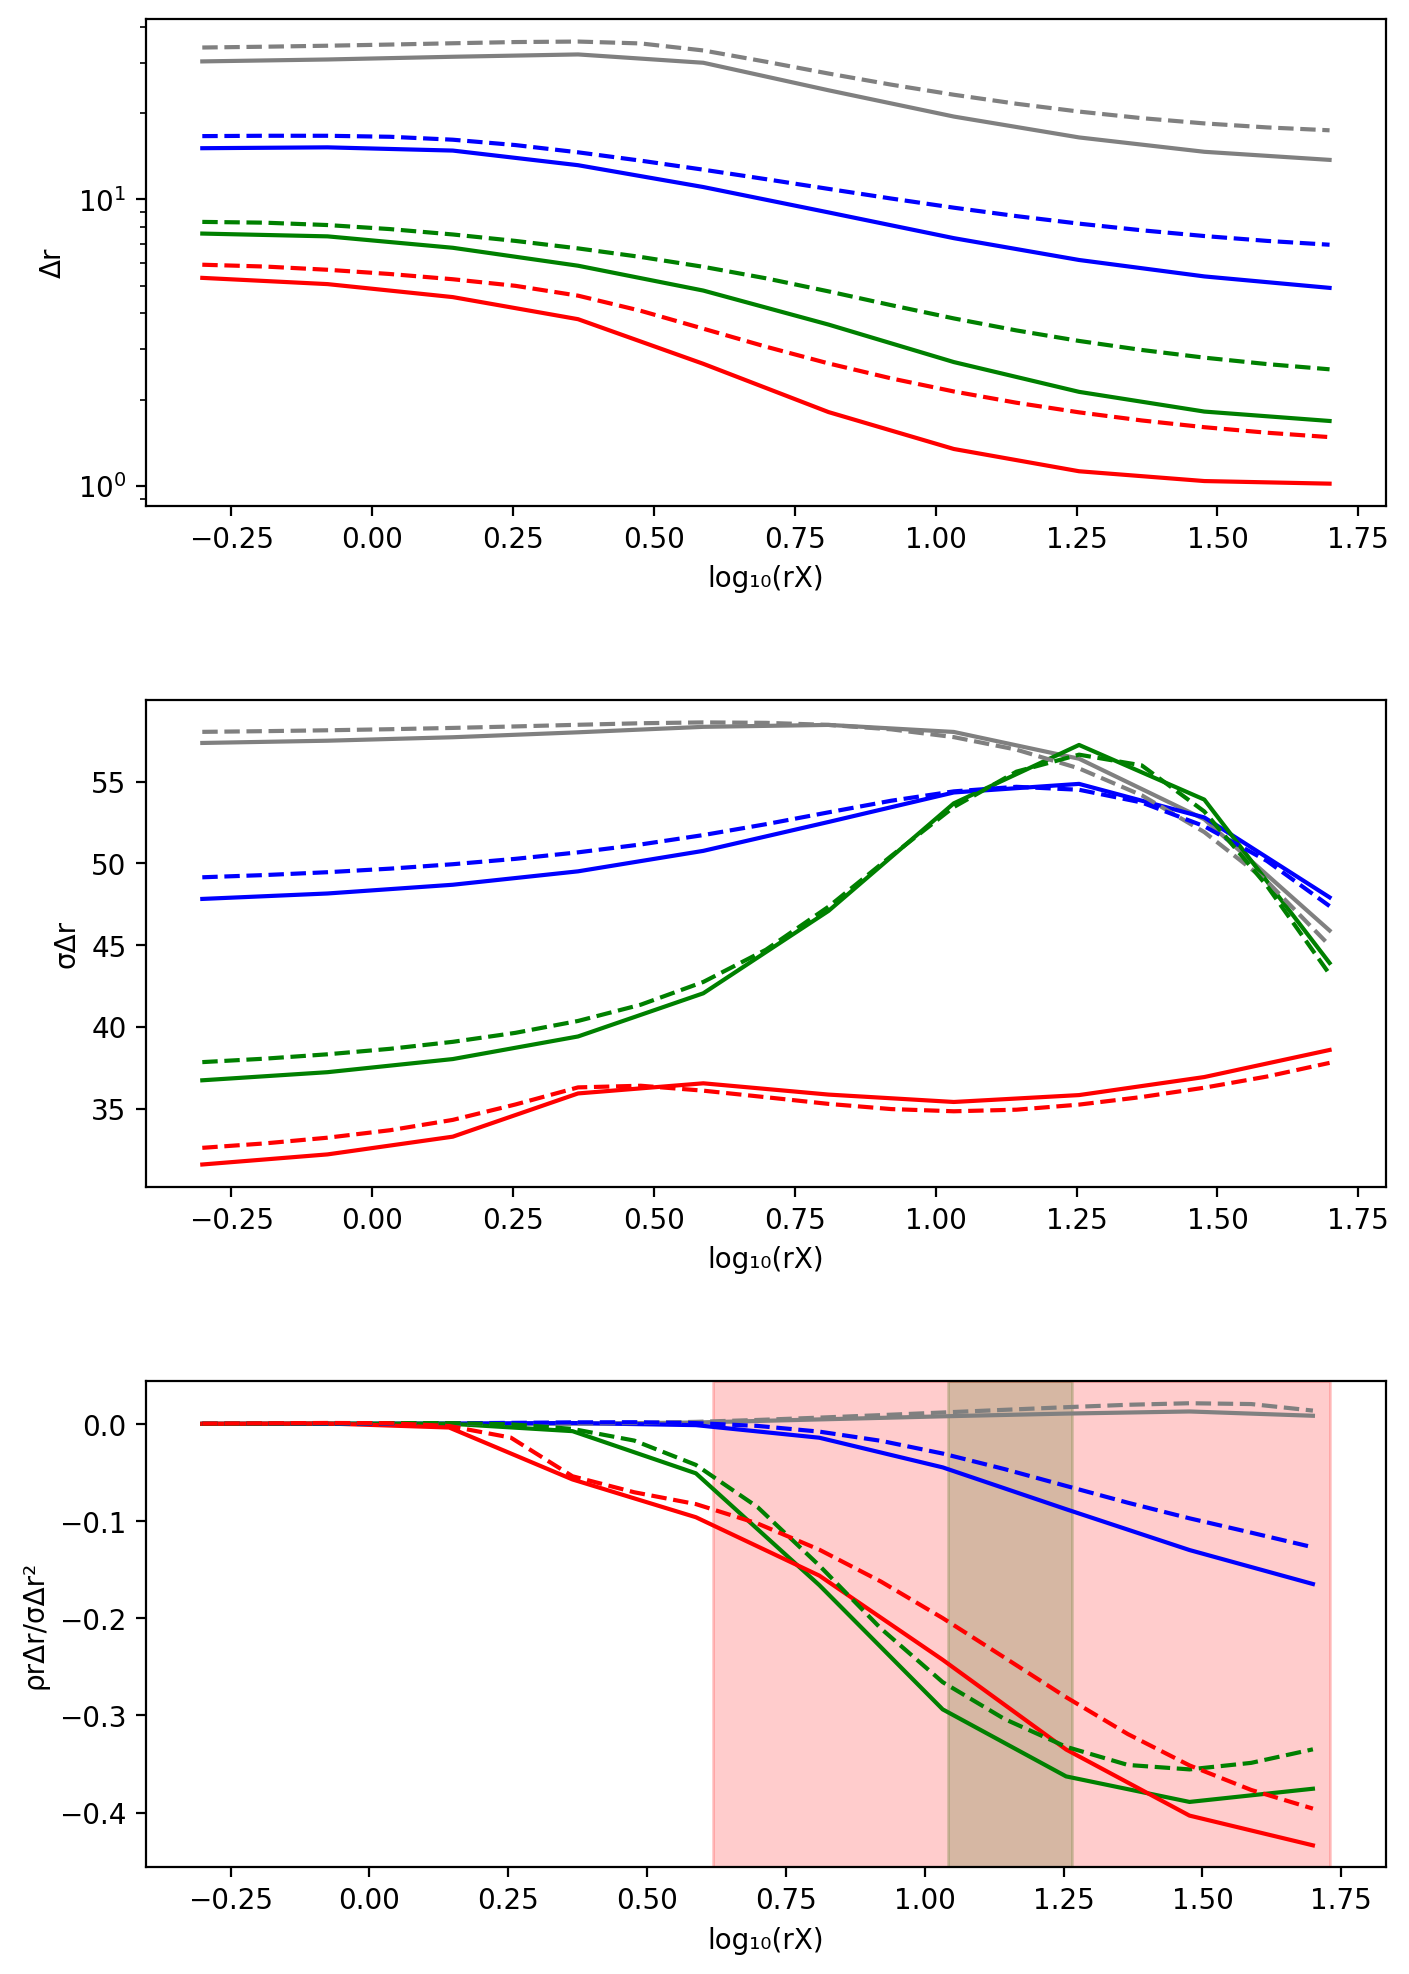

PyObject Text(48.000000000000014, 0.5, 'ρrΔr/σΔr²')

In [90]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log10.(rXAs),0.8ΔrETAs[1,:]+0.2ΔrITAs[1,:],"gray")
plot(log10.(rXAs),0.8ΔrETAs[2,:]+0.2ΔrITAs[2,:],"b")
plot(log10.(rXAs),0.8ΔrETAs[3,:]+0.2ΔrITAs[3,:],"g")
plot(log10.(rXAs),0.8ΔrETAs[4,:]+0.2ΔrITAs[4,:],"r")
plot(log10.(rXA2s),0.8ΔrEAs[1,:]+0.2ΔrIAs[1,:],"gray",ls="--")
plot(log10.(rXA2s),0.8ΔrEAs[2,:]+0.2ΔrIAs[2,:],"b",ls="--")
plot(log10.(rXA2s),0.8ΔrEAs[3,:]+0.2ΔrIAs[3,:],"g",ls="--")
plot(log10.(rXA2s),0.8ΔrEAs[4,:]+0.2ΔrIAs[4,:],"r",ls="--")
xlabel("log₁₀(rX)")
ylabel("Δr")
yscale("log")

subplot(3,1,2)
plot(log10.(rXAs),.√(max.(0.8σΔrET2As[1,:]+0.2σΔrIT2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(0.8σΔrET2As[2,:]+0.2σΔrIT2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(0.8σΔrET2As[3,:]+0.2σΔrIT2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(0.8σΔrET2As[4,:]+0.2σΔrIT2As[4,:],0)),"r")
plot(log10.(rXA2s),.√(max.(0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:],0)),"gray",ls="--")
plot(log10.(rXA2s),.√(max.(0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:],0)),"b",ls="--")
plot(log10.(rXA2s),.√(max.(0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:],0)),"g",ls="--")
plot(log10.(rXA2s),.√(max.(0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:],0)),"r",ls="--")
xlabel("log₁₀(rX)")
ylabel("σΔr")

subplot(3,1,3)
plot(log10.(rXAs),(0.8ρrETΔrETAs[1,:]+0.2ρrITΔrITAs[1,:])./
                    (0.8σΔrET2As[1,:]+0.2σΔrIT2As[1,:]),"gray")
plot(log10.(rXAs),(0.8ρrETΔrETAs[2,:]+0.2ρrITΔrITAs[2,:])./
                    (0.8σΔrET2As[2,:]+0.2σΔrIT2As[2,:]),"b")
plot(log10.(rXAs),(0.8ρrETΔrETAs[3,:]+0.2ρrITΔrITAs[3,:])./
                    (0.8σΔrET2As[3,:]+0.2σΔrIT2As[3,:]),"g")
plot(log10.(rXAs),(0.8ρrETΔrETAs[4,:]+0.2ρrITΔrITAs[4,:])./
                    (0.8σΔrET2As[4,:]+0.2σΔrIT2As[4,:]),"r")
plot(log10.(rXA2s),(0.8ρrEΔrEAs[1,:]+0.2ρrIΔrIAs[1,:])./
                    (0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:]),"gray",ls="--")
plot(log10.(rXA2s),(0.8ρrEΔrEAs[2,:]+0.2ρrIΔrIAs[2,:])./
                    (0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:]),"b",ls="--")
plot(log10.(rXA2s),(0.8ρrEΔrEAs[3,:]+0.2ρrIΔrIAs[3,:])./
                    (0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:]),"g",ls="--")
plot(log10.(rXA2s),(0.8ρrEΔrEAs[4,:]+0.2ρrIΔrIAs[4,:])./
                    (0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:]),"r",ls="--")
if any(chAs[1,:])
    axvline(log10.(rXAs[findfirst(chAs[1,:])])-0.03,color="gray",ls="--")
end
if any(chAs[2,:])
    axvspan(log10.(rXAs[findfirst(chAs[2,:])])-0.01,
        log10.(rXAs[findlast(chAs[2,:])])-0.01,color="b",alpha=0.2)
end
if any(chAs[3,:])
    axvspan(log10.(rXAs[findfirst(chAs[3,:])])+0.01,
        log10.(rXAs[findlast(chAs[3,:])])+0.01,color="g",alpha=0.2)
end
if any(chAs[4,:])
    axvspan(log10.(rXAs[findfirst(chAs[4,:])])+0.03,
        log10.(rXAs[findlast(chAs[4,:])])+0.03,color="r",alpha=0.2)
end
xlabel("log₁₀(rX)")
ylabel("ρrΔr/σΔr²")

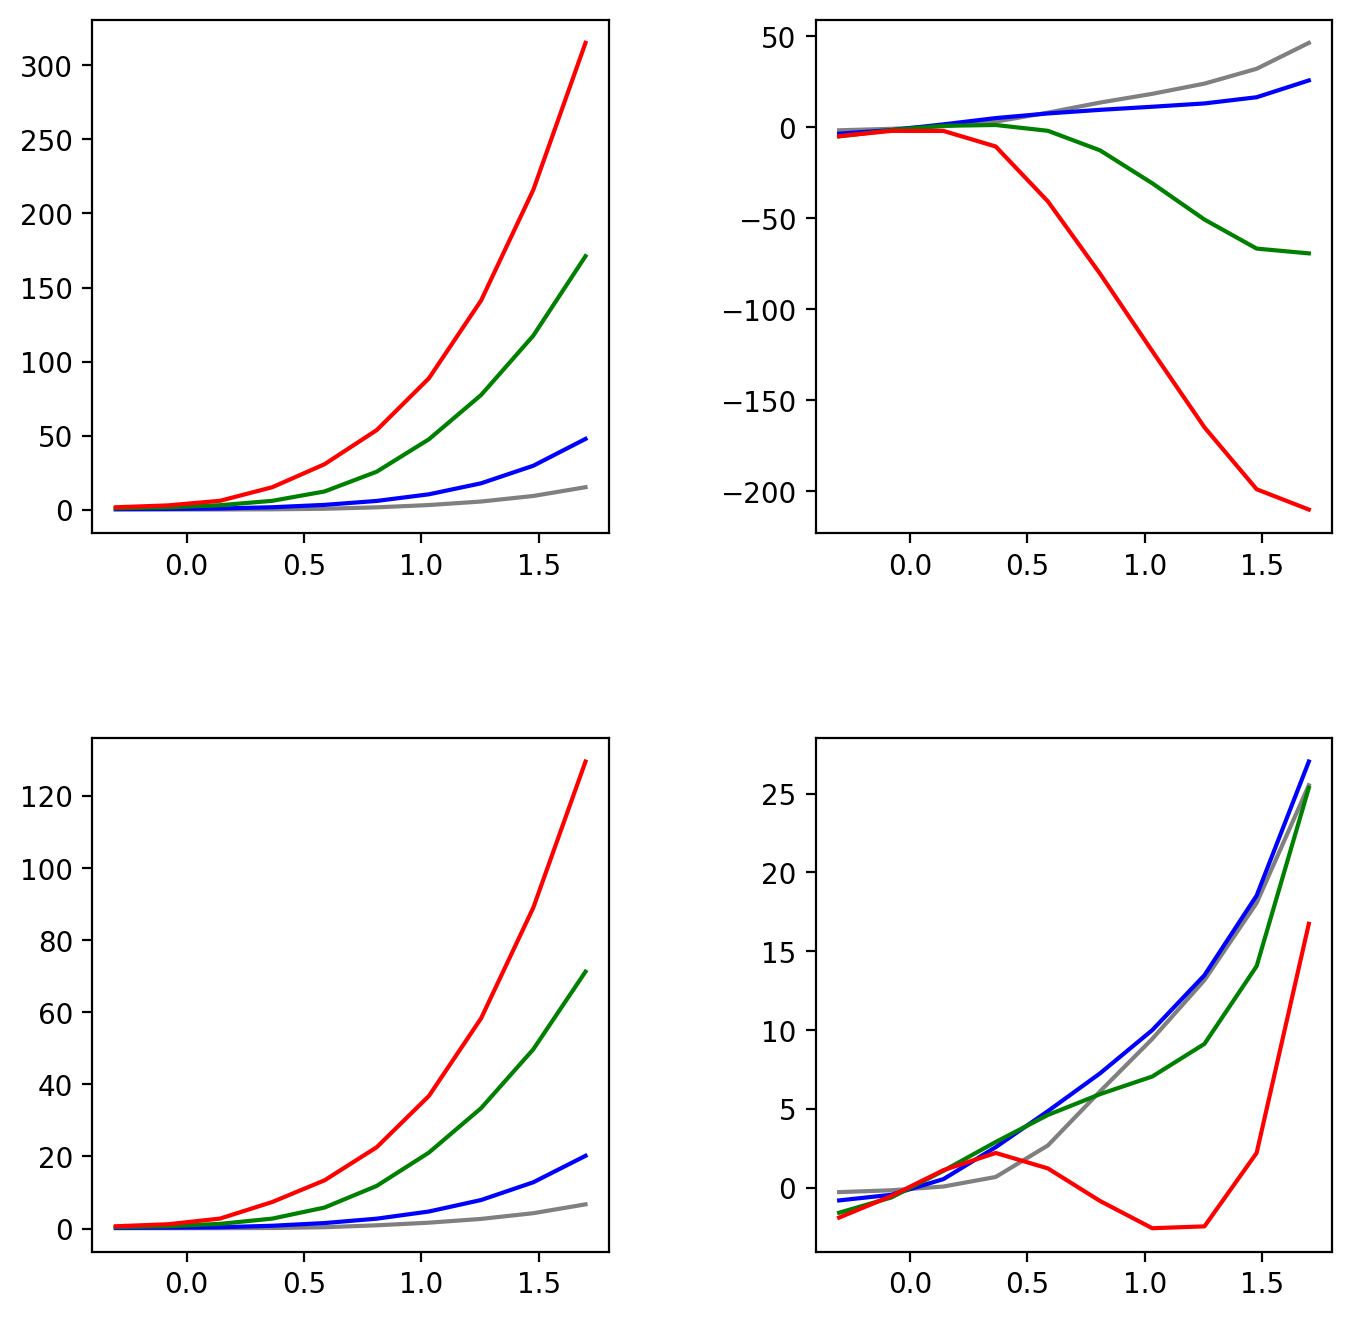

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fea91b697f0>

In [91]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,2,1)
plot(log10.(rXAs),.√(max.(σμET2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμET2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμET2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμET2As[4,:],0)),"r")

subplot(2,2,3)
plot(log10.(rXAs),.√(max.(σμIT2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμIT2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμIT2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμIT2As[4,:],0)),"r")

subplot(2,2,2)
plot(log10.(rXAs),μETAs[1,:],"gray")
plot(log10.(rXAs),μETAs[2,:],"b")
plot(log10.(rXAs),μETAs[3,:],"g")
plot(log10.(rXAs),μETAs[4,:],"r")

subplot(2,2,4)
plot(log10.(rXAs),μITAs[1,:],"gray")
plot(log10.(rXAs),μITAs[2,:],"b")
plot(log10.(rXAs),μITAs[3,:],"g")
plot(log10.(rXAs),μITAs[4,:],"r")

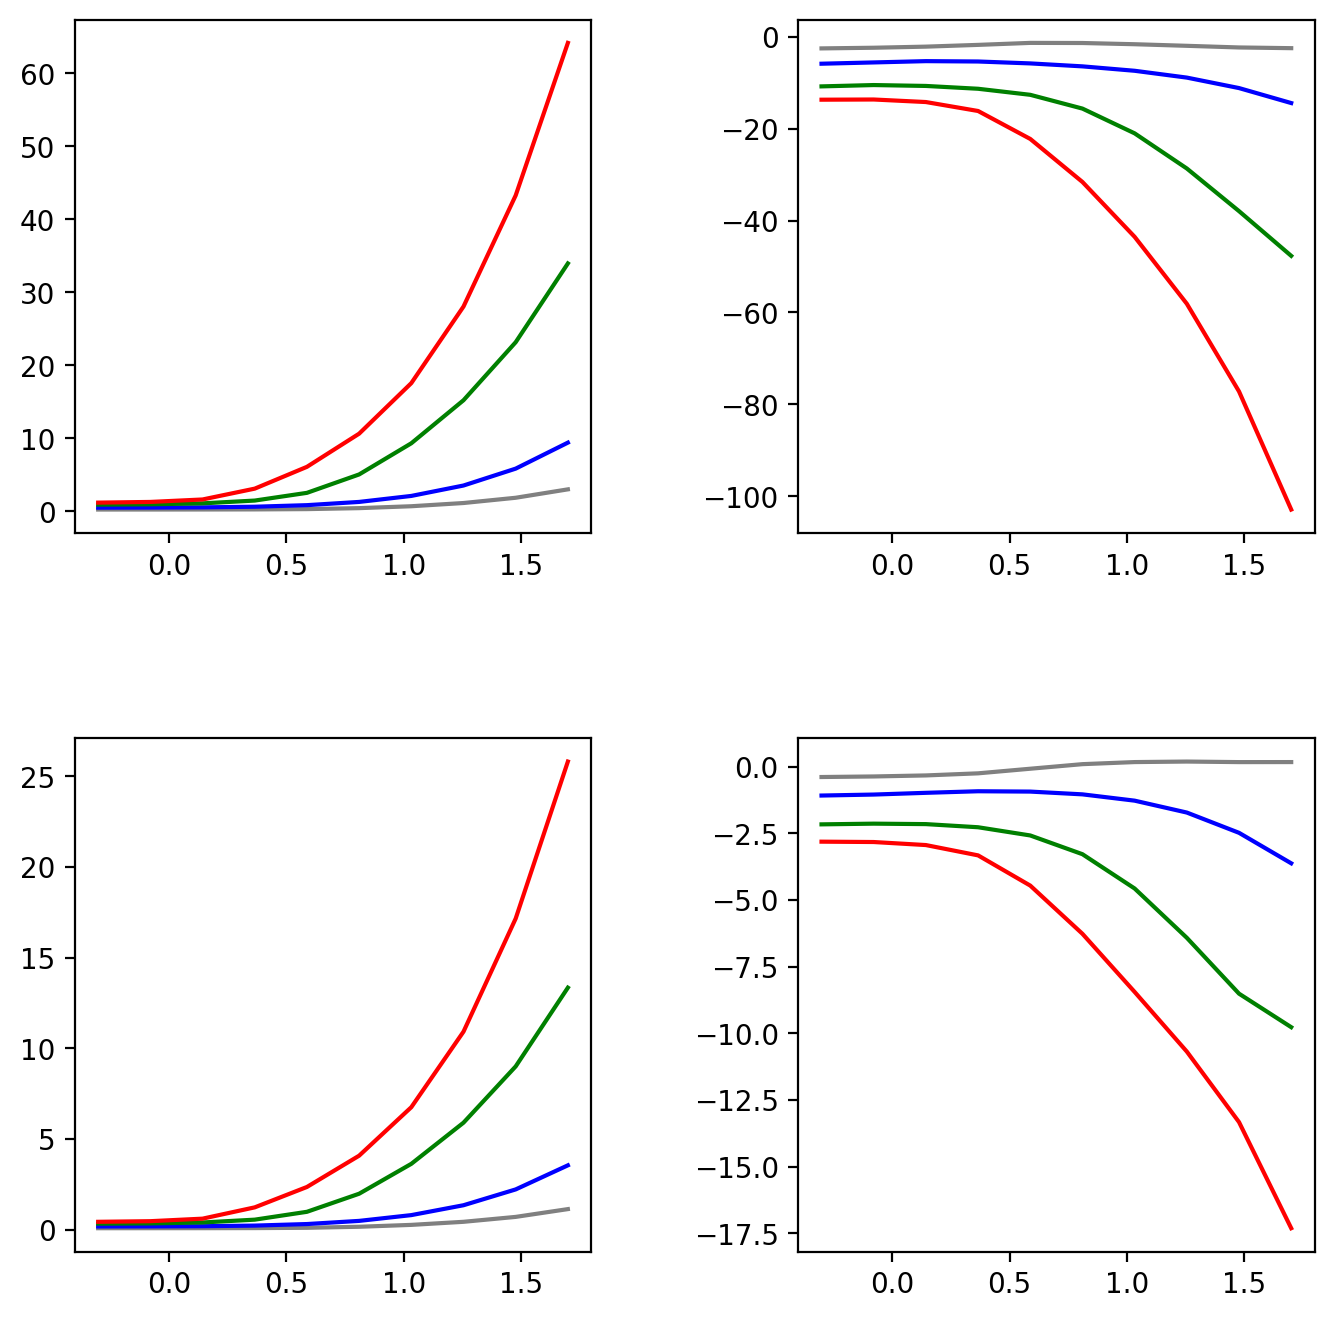

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fea91fca430>

In [92]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,2,1)
plot(log10.(rXAs),.√(max.(σμEU2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμEU2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμEU2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμEU2As[4,:],0)),"r")

subplot(2,2,3)
plot(log10.(rXAs),.√(max.(σμIU2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμIU2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμIU2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμIU2As[4,:],0)),"r")

subplot(2,2,2)
plot(log10.(rXAs),μEUAs[1,:],"gray")
plot(log10.(rXAs),μEUAs[2,:],"b")
plot(log10.(rXAs),μEUAs[3,:],"g")
plot(log10.(rXAs),μEUAs[4,:],"r")

subplot(2,2,4)
plot(log10.(rXAs),μIUAs[1,:],"gray")
plot(log10.(rXAs),μIUAs[2,:],"b")
plot(log10.(rXAs),μIUAs[3,:],"g")
plot(log10.(rXAs),μIUAs[4,:],"r")